In [1]:
#Import package pandas for data analysis
import pandas as pd
# Import package numpy for numeric computing
import numpy as np
from numpy import int64
from numpy import float64
from numpy import datetime64
# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
# Allows plots to appear directly in the notebook.
%matplotlib inline
# For dealing with some Accented characters (in Irish Place names)
import unidecode
# Date/time functionality
import datetime
import time
#for trigonometic calculations
import math
# Check if files exist
from os.path import exists
from os import makedirs
# System specific parameters and functions
import sys
# look at some z-scores for inspecting outliers.
from scipy import stats
import seaborn as sb
# lookup lat/long and convert lat/long to national grid references.
#import geopy
#import pyproj

from patsy import dmatrices
from sklearn import metrics
#binary encoding by using the OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
#from sklearn.tree import export_text

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

#import graphviz
#from graphviz import Source
#to read all CSV files in a folder
import os
import glob

#### Functions generated at notebooks that might be useful

In [3]:
#method to read chunks from a file and create a dataframe list.
def get_chunks(x):
    """x=[location, dtypes, datecolumns ,date_parser_func, cols]
    exp:mydateparser = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")
    exp:dtypes={'TRIPID' :'category','PROGRNUMBER':'int16','STOPPOINTID':'category','PLANNEDTIME_ARR':'int64','PLANNEDTIME_DEP':'int64','ACTUALTIME_ARR':'int64','ACTUALTIME_DEP':'int64','DIFFERENCETIME_ARR':'int64','DIFFERENCETIME_DEP':'int64','LINEID':'category','ROUTEID':'category','DIRECTION':'category','TRIPS_TIME_PROPORTION':'float32','TOTAL_JOURNEY_TIME':'int16','TIME_OF_DAY':'category','DAY_OF_WEEK':'category'}
    exp:cols=['Date time','Temperature','Wind Speed','Precipitation','Cloud Cover']
    exp:x=['/Chunks/DBUS/QP_Implementation',dtypes,['ACTUALTIME_ARR_DATETIME'],mydateparser, cols]"""
    cwd=os.getcwd()
    path = cwd+x[0]
    chunk_folder = glob.glob(os.path.join(path, "*.csv"))
    chunk_list=[]
    counter=0
    for filename in chunk_folder:
        # read the csv file
        if len(x)==4:
            df_chunk = pd.read_csv(filename, low_memory=False, dtype=x[1],parse_dates=x[2],date_parser=x[3])
        else:
            df_chunk = pd.read_csv(filename,usecols=x[4], low_memory=False, dtype=x[1],parse_dates=x[2],date_parser=x[3])
        chunk_list.append(df_chunk)
        print('Index at chunk_list',counter,' is ', filename, ': ',df_chunk.shape)
        counter+=1
    return chunk_list
#chunk_dbus_list=get_chunks(arg_list)

In [4]:
#method to parse dates
mydateparser = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")

In [5]:
#method that mathes list index in a dataframe list with id information in dataframe's column. 
#for this method to work id column should be constant. 
def id_list_index_matcher(df_list, column_name):
    df_id_list_index = pd.DataFrame()
    index_count=0
    for df in df_list:
        a=df[column_name].unique()
        df_id_list_index=df_id_list_index.append({'List_index':index_count,column_name:a[0]},ignore_index=True)
        index_count+=1
    return df_id_list_index

In [6]:
#methods that create csv files from dataframe list by naming them with unique value in id column.
#for this method to work id column should be constant. 
def write_to_csv(adress,df_list,id_column ):
    cwd=os.getcwd()
    path = cwd+adress
    for df in df_list:
        a=df[id_column].unique()
        file_name=a[0]
        saved_file_name=file_name+'.csv'
        my_file_bool=os.path.exists(path+saved_file_name)
        if my_file_bool==False:
            df.to_csv(path+saved_file_name,index=False)
            print('Location:', path+saved_file_name)

In [7]:
def write_to_csv_n_r_p(adress,df_list,id_column ):
    """without relative path input"""
    path = adress
    for df in df_list:
        a=df[id_column].unique()
        file_name=a[0]
        saved_file_name=file_name+'.csv'
        my_file_bool=os.path.exists(path+saved_file_name)
        if my_file_bool==False:
            df.to_csv(path+saved_file_name,index=False)
            print('Location:', path+saved_file_name)

In [8]:
#method that takes a dataframe list and prints list lenght and sum of all rows in all dataframes
def df_list_checker(dflist):
    print("number of df in list: ",len(dflist))
    row_count=0
    for df in dflist:
        row_count+=df.shape[0]
    print("number of rows of data in list: ", row_count)

In [9]:
#method to yield(return generator object) dfs for memory efficent concat( to avoid expotential memory use)
#https://stackoverflow.com/questions/70911236/how-can-i-concat-the-huge-pandas-dataframes-into-one
def yield_dfs(x):
    """x=[location, dtypes, datecolumns ,date_parser_func]
    exp:mydateparser = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S")
    exp:dtypes={'TRIPID' :'category','PROGRNUMBER':'int16','STOPPOINTID':'category','PLANNEDTIME_ARR':'int64','PLANNEDTIME_DEP':'int64','ACTUALTIME_ARR':'int64','ACTUALTIME_DEP':'int64','DIFFERENCETIME_ARR':'int64','DIFFERENCETIME_DEP':'int64','LINEID':'category','ROUTEID':'category','DIRECTION':'category','TRIPS_TIME_PROPORTION':'float32','TOTAL_JOURNEY_TIME':'int16','TIME_OF_DAY':'category','DAY_OF_WEEK':'category'}
    exp:x=['/Chunks/DBUS/QP_Implementation',dtypes,['ACTUALTIME_ARR_DATETIME'],mydateparser]"""
    cwd=os.getcwd()
    path = cwd+x[0]
    file_list = glob.glob(os.path.join(path, "*.csv"))
    """generator function to yield dataframes."""
    for filename in file_list:
        df = pd.read_csv(filename, low_memory=False, dtype=x[1],parse_dates=x[2],date_parser=x[3],index_col=False)
        print(df.shape)
        yield df

#df_dbus = pd.concat(yield_dfs(x), axis=0,ignore_index=True)

In [10]:
#method that takes a directory and reads all files inside that directory and its subdirectories 
#creates a dataframe from them and add to dataframe list
def get_chunks_subdirectory(location):
    cwd=os.getcwd()
    adress=location
    path = cwd+adress
    chunk_list=[]
    for root, dirnames, files in os.walk(path):
        print(dirnames)
        print('='*66)
        for mfile in files:
            # read the csv file
            df_chunk = pd.read_csv(os.path.join(root, mfile), low_memory=False)
            chunk_list.append(df_chunk)
            print('Location:', mfile)
    return chunk_list
#chunk_dbus_list_v2=get_chunks_subdirectory('/Chunks/DBUS/LINEID_CHUNKS/')

In [10]:
cols=['TRIPID','PROGRNUMBER','PLANNEDTIME_DEP','ROUTEID','ACTUALTIME_ARR_DATETIME','TOTAL_JOURNEY_TIME','TIME_OF_DAY','DAY_OF_WEEK','TRIPS_TIME_PROPORTION_v2','PLANNEDTIME_DEP_R_M5','rain','temp','wet_bulb_temp(C)','dew_pt_temp(C)','vapour_pressure(hPa)','humidity(%)','sea_lvl_pressure(hPa)']
dtypes={'TRIPID' :'category','PROGRNUMBER':'int16','PLANNEDTIME_DEP':'int64','ROUTEID':'category','TOTAL_JOURNEY_TIME':'int16','TIME_OF_DAY':'category','DAY_OF_WEEK':'category','TRIPS_TIME_PROPORTION_v2':'float32','PLANNEDTIME_DEP_R_M5':'category','rain':'float16','temp':'float16','wet_bulb_temp(C)':'float16','dew_pt_temp(C)':'float16','vapour_pressure(hPa)':'float16','humidity(%)':'int16','sea_lvl_pressure(hPa)':'float16'}
x=['/Chunks/DBUS/Merging_implementation',dtypes,['ACTUALTIME_ARR_DATETIME'],mydateparser, cols]

In [11]:
dbus_df_list=get_chunks(x)

Index at chunk_list 0  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/33D_61.csv :  (4575, 17)
Index at chunk_list 1  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/15B_56.csv :  (2821, 17)
Index at chunk_list 2  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/18_3.csv :  (826557, 17)
Index at chunk_list 3  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/67_6.csv :  (775062, 17)
Index at chunk_list 4  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/75_20.csv :  (15926, 17)
Index at chunk_list 5  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/142_9.csv :  (23881, 17)
Index at chunk_list 6  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/145_107.csv :  (5463, 17)
Index at chunk_list 7  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/17_16.csv :  (29666, 17)
Index at chunk_list 8  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementatio

Index at chunk_list 71  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/84A_3.csv :  (54410, 17)
Index at chunk_list 72  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/25X_11.csv :  (16282, 17)
Index at chunk_list 73  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/41_10.csv :  (7605, 17)
Index at chunk_list 74  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/41_6.csv :  (10461, 17)
Index at chunk_list 75  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/15B_64.csv :  (190587, 17)
Index at chunk_list 76  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/4_13.csv :  (10257, 17)
Index at chunk_list 77  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/77A_29.csv :  (930359, 17)
Index at chunk_list 78  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/44_40.csv :  (439568, 17)
Index at chunk_list 79  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_im

Index at chunk_list 144  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/16_23.csv :  (54287, 17)
Index at chunk_list 145  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/14C_10.csv :  (161, 17)
Index at chunk_list 146  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/17A_17.csv :  (587575, 17)
Index at chunk_list 147  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/140_22.csv :  (6591, 17)
Index at chunk_list 148  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/142_13.csv :  (41024, 17)
Index at chunk_list 149  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/111_10.csv :  (3552, 17)
Index at chunk_list 150  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/14_16.csv :  (1290699, 17)
Index at chunk_list 151  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/15A_83.csv :  (614112, 17)
Index at chunk_list 152  is  /home/team8/notebook/Pelin/Chunks/DBU

Index at chunk_list 215  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/114_6.csv :  (141552, 17)
Index at chunk_list 216  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/15D_65.csv :  (1811, 17)
Index at chunk_list 217  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/84X_62.csv :  (45909, 17)
Index at chunk_list 218  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/77X_61.csv :  (12738, 17)
Index at chunk_list 219  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/7A_86.csv :  (180619, 17)
Index at chunk_list 220  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/270_42.csv :  (95202, 17)
Index at chunk_list 221  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/7A_89.csv :  (90863, 17)
Index at chunk_list 222  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/111_7.csv :  (178931, 17)
Index at chunk_list 223  is  /home/team8/notebook/Pelin/Chunks/DBU

Index at chunk_list 288  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/66B_57.csv :  (85059, 17)
Index at chunk_list 289  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/239_26.csv :  (105100, 17)
Index at chunk_list 290  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/13_65.csv :  (131825, 17)
Index at chunk_list 291  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/84X_57.csv :  (40425, 17)
Index at chunk_list 292  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/41_8.csv :  (45702, 17)
Index at chunk_list 293  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/63_31.csv :  (8154, 17)
Index at chunk_list 294  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/67X_42.csv :  (7079, 17)
Index at chunk_list 295  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/54A_11.csv :  (407360, 17)
Index at chunk_list 296  is  /home/team8/notebook/Pelin/Chunks/DBUS

Index at chunk_list 359  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/15B_60.csv :  (804882, 17)
Index at chunk_list 360  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/25X_7.csv :  (3135, 17)
Index at chunk_list 361  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/151_19.csv :  (14181, 17)
Index at chunk_list 362  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/185_54.csv :  (5892, 17)
Index at chunk_list 363  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/79_10.csv :  (359176, 17)
Index at chunk_list 364  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/67X_40.csv :  (2489, 17)
Index at chunk_list 365  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/15A_84.csv :  (501677, 17)
Index at chunk_list 366  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/16_20.csv :  (1533552, 17)
Index at chunk_list 367  is  /home/team8/notebook/Pelin/Chunks/DB

Index at chunk_list 431  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/33A_26.csv :  (21346, 17)
Index at chunk_list 432  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/27_12.csv :  (52888, 17)
Index at chunk_list 433  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/7A_85.csv :  (526150, 17)
Index at chunk_list 434  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/33_70.csv :  (410226, 17)
Index at chunk_list 435  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/238_11.csv :  (98449, 17)
Index at chunk_list 436  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/15_10.csv :  (9388, 17)
Index at chunk_list 437  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/66X_96.csv :  (4752, 17)
Index at chunk_list 438  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/46E_93.csv :  (4100, 17)
Index at chunk_list 439  is  /home/team8/notebook/Pelin/Chunks/DBUS/M

Index at chunk_list 502  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/13_67.csv :  (767187, 17)
Index at chunk_list 503  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/67X_45.csv :  (15202, 17)
Index at chunk_list 504  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/66_17.csv :  (403689, 17)
Index at chunk_list 505  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/41X_127.csv :  (1756, 17)
Index at chunk_list 506  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/31_15.csv :  (595586, 17)
Index at chunk_list 507  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/31A_26.csv :  (217823, 17)
Index at chunk_list 508  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/25D_277.csv :  (24270, 17)
Index at chunk_list 509  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/70D_71.csv :  (7204, 17)
Index at chunk_list 510  is  /home/team8/notebook/Pelin/Chunks/

Index at chunk_list 574  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/83A_20.csv :  (48092, 17)
Index at chunk_list 575  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/39_20.csv :  (802676, 17)
Index at chunk_list 576  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/63_26.csv :  (230720, 17)
Index at chunk_list 577  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/66B_58.csv :  (161625, 17)
Index at chunk_list 578  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/42D_50.csv :  (5484, 17)
Index at chunk_list 579  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/236_10.csv :  (14681, 17)
Index at chunk_list 580  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/17_10.csv :  (508784, 17)
Index at chunk_list 581  is  /home/team8/notebook/Pelin/Chunks/DBUS/Merging_implementation/41X_119.csv :  (168, 17)
Index at chunk_list 582  is  /home/team8/notebook/Pelin/Chunks/DB

In [12]:
dbus_df_list[30].head()

,TRIPID,PROGRNUMBER,PLANNEDTIME_DEP,ROUTEID,ACTUALTIME_ARR_DATETIME,TOTAL_JOURNEY_TIME,TIME_OF_DAY,DAY_OF_WEEK,TRIPS_TIME_PROPORTION_v2,PLANNEDTIME_DEP_R_M5,rain,temp,wet_bulb_temp(C),dew_pt_temp(C),vapour_pressure(hPa),humidity(%),sea_lvl_pressure(hPa)
0,6371214,1,19200,7D_123,2018-03-05 05:19:12,4964,05,Monday,0.000000,05:20,0.199951,3.400391,3.300781,3.199219,7.699219,98,983.0
1,6371214,2,19214,7D_123,2018-03-05 05:20:06,4964,05,Monday,0.010878,05:20,0.199951,3.400391,3.300781,3.199219,7.699219,98,983.0
2,6371214,3,19222,7D_123,2018-03-05 05:20:38,4964,05,Monday,0.017325,05:20,0.199951,3.400391,3.300781,3.199219,7.699219,98,983.0
3,6371214,9,19310,7D_123,2018-03-05 05:26:19,4964,05,Monday,0.086019,05:20,0.199951,3.400391,3.300781,3.199219,7.699219,98,983.0
4,6371214,10,19316,7D_123,2018-03-05 05:26:38,4964,05,Monday,0.089847,05:20,0.199951,3.400391,3.300781,3.199219,7.699219,98,983.0


#### Encoding time of day category

To encode this category we will establish 2 new feature which will cumilatively balance weight of each item in category. To balance weight of each item in category yet be able differentiate between, we represent a clock with a unit circle and match hours of day with angles. In order to match hours with angles we will use the formula: \begin{equation} angle=\frac{hour}{24}360  \end{equation} 
Then we will have 2 columns to represent hour of day; one will be sin(angle) and other will be cos(angle) which will prepresents location of hour in unit circle. We can use this method because hour of day is circular category and hour 24 is equal to hour 0 which is perfectly represented by unit circle where sin and cos values of 360 degree is equal to sin and cos values of 0 degree. Then maksimum of correlation value between these features and our prediction target, will give us idea about feature importance. In the end we will do a model with and without these features and check R square to measure category impact encoded while using this technique. 

In [13]:
for df in dbus_df_list:
    print('='*66)
    print("ROUTEID is ",df['ROUTEID'].unique()[0])
    df['sin_hour_of_day']=np.sin(np.deg2rad((df['TIME_OF_DAY'].astype('int16')/24)*360))

ROUTEID is  33D_61
ROUTEID is  15B_56
ROUTEID is  18_3
ROUTEID is  67_6
ROUTEID is  75_20
ROUTEID is  142_9
ROUTEID is  145_107
ROUTEID is  17_16
ROUTEID is  46A_74
ROUTEID is  122_14
ROUTEID is  145_95
ROUTEID is  150_8
ROUTEID is  41_20
ROUTEID is  33X_49
ROUTEID is  83_19
ROUTEID is  11_43
ROUTEID is  270_44
ROUTEID is  84_30
ROUTEID is  130_10
ROUTEID is  41X_118
ROUTEID is  40_30
ROUTEID is  84X_56
ROUTEID is  84X_58
ROUTEID is  66A_36
ROUTEID is  46A_66
ROUTEID is  51X_64
ROUTEID is  102_8
ROUTEID is  41X_121
ROUTEID is  41X_122
ROUTEID is  68_81
ROUTEID is  7D_123
ROUTEID is  66_11
ROUTEID is  26_28
ROUTEID is  38D_61
ROUTEID is  104_15
ROUTEID is  44_33
ROUTEID is  40_31
ROUTEID is  15_19
ROUTEID is  66X_100
ROUTEID is  53_22
ROUTEID is  145_99
ROUTEID is  145_106
ROUTEID is  76_37
ROUTEID is  41_5
ROUTEID is  185_57
ROUTEID is  13_74
ROUTEID is  67_4
ROUTEID is  13_68
ROUTEID is  46A_71
ROUTEID is  70D_70
ROUTEID is  61_109
ROUTEID is  39A_41
ROUTEID is  38_9
ROUTEID is  83_21

ROUTEID is  83A_26
ROUTEID is  27B_38
ROUTEID is  120_8
ROUTEID is  38B_45
ROUTEID is  17_15
ROUTEID is  66X_92
ROUTEID is  51X_63
ROUTEID is  31D_50
ROUTEID is  1_38
ROUTEID is  46A_72
ROUTEID is  67X_39
ROUTEID is  27B_23
ROUTEID is  13_72
ROUTEID is  47_137
ROUTEID is  27B_40
ROUTEID is  46A_77
ROUTEID is  83A_17
ROUTEID is  33_45
ROUTEID is  41X_123
ROUTEID is  15_17
ROUTEID is  123_36
ROUTEID is  40D_101
ROUTEID is  14C_17
ROUTEID is  66X_95
ROUTEID is  14_15
ROUTEID is  185_61
ROUTEID is  40D_106
ROUTEID is  111_8
ROUTEID is  84A_1
ROUTEID is  54A_12
ROUTEID is  44_39
ROUTEID is  63_27
ROUTEID is  65_77
ROUTEID is  41_24
ROUTEID is  67X_44
ROUTEID is  75_21
ROUTEID is  66B_55
ROUTEID is  4_14
ROUTEID is  9_7
ROUTEID is  79A_28
ROUTEID is  75_18
ROUTEID is  142_12
ROUTEID is  41_4
ROUTEID is  84X_63
ROUTEID is  27_18
ROUTEID is  16_23
ROUTEID is  14C_10
ROUTEID is  17A_17
ROUTEID is  140_22
ROUTEID is  142_13
ROUTEID is  111_10
ROUTEID is  14_16
ROUTEID is  15A_83
ROUTEID is  84X_

ROUTEID is  15D_65
ROUTEID is  84X_62
ROUTEID is  77X_61
ROUTEID is  7A_86
ROUTEID is  270_42
ROUTEID is  7A_89
ROUTEID is  111_7
ROUTEID is  27X_43
ROUTEID is  40_29
ROUTEID is  41X_131
ROUTEID is  185_50
ROUTEID is  26_24
ROUTEID is  40_32
ROUTEID is  84_28
ROUTEID is  17A_11
ROUTEID is  122_15
ROUTEID is  7_74
ROUTEID is  16C_29
ROUTEID is  33D_62
ROUTEID is  38B_44
ROUTEID is  27_19
ROUTEID is  84_27
ROUTEID is  7_66
ROUTEID is  15B_61
ROUTEID is  123_37
ROUTEID is  27_20
ROUTEID is  69X_60
ROUTEID is  39A_45
ROUTEID is  142_8
ROUTEID is  27B_34
ROUTEID is  33B_59
ROUTEID is  84X_52
ROUTEID is  15D_62
ROUTEID is  70_67
ROUTEID is  44B_61
ROUTEID is  77X_62
ROUTEID is  45A_64
ROUTEID is  31B_45
ROUTEID is  41C_83
ROUTEID is  145_108
ROUTEID is  161_51
ROUTEID is  33X_46
ROUTEID is  38_15
ROUTEID is  46A_65
ROUTEID is  32X_77
ROUTEID is  116_1
ROUTEID is  65_76
ROUTEID is  122_21
ROUTEID is  68_80
ROUTEID is  41X_116
ROUTEID is  41B_52
ROUTEID is  46A_62
ROUTEID is  15D_63
ROUTEID is

ROUTEID is  151_17
ROUTEID is  70_60
ROUTEID is  4_11
ROUTEID is  67X_47
ROUTEID is  27B_35
ROUTEID is  25A_270
ROUTEID is  118_3
ROUTEID is  32_57
ROUTEID is  13_28
ROUTEID is  41B_53
ROUTEID is  67X_41
ROUTEID is  14C_18
ROUTEID is  53_23
ROUTEID is  145_89
ROUTEID is  44_36
ROUTEID is  61_106
ROUTEID is  33A_23
ROUTEID is  41C_78
ROUTEID is  1_39
ROUTEID is  65B_66
ROUTEID is  49_27
ROUTEID is  38_14
ROUTEID is  18_4
ROUTEID is  66_16
ROUTEID is  39A_42
ROUTEID is  61_108
ROUTEID is  25X_12
ROUTEID is  102_10
ROUTEID is  68_85
ROUTEID is  83_18
ROUTEID is  63_28
ROUTEID is  83_29
ROUTEID is  11_42
ROUTEID is  29A_14
ROUTEID is  13_75
ROUTEID is  17A_12
ROUTEID is  46A_73
ROUTEID is  15B_60
ROUTEID is  25X_7
ROUTEID is  151_19
ROUTEID is  185_54
ROUTEID is  79_10
ROUTEID is  67X_40
ROUTEID is  15A_84
ROUTEID is  16_20
ROUTEID is  33_69
ROUTEID is  27B_39
ROUTEID is  31A_25
ROUTEID is  65_72
ROUTEID is  33B_58
ROUTEID is  41X_108
ROUTEID is  33X_48
ROUTEID is  69X_59
ROUTEID is  31_16

ROUTEID is  122_18
ROUTEID is  7B_91
ROUTEID is  140_20
ROUTEID is  122_17
ROUTEID is  68_78
ROUTEID is  76A_29
ROUTEID is  66A_34
ROUTEID is  7D_121
ROUTEID is  66X_106
ROUTEID is  33A_26
ROUTEID is  27_12
ROUTEID is  7A_85
ROUTEID is  33_70
ROUTEID is  238_11
ROUTEID is  15_10
ROUTEID is  66X_96
ROUTEID is  46E_93
ROUTEID is  68_82
ROUTEID is  33A_27
ROUTEID is  63_25
ROUTEID is  104_16
ROUTEID is  69_45
ROUTEID is  41_22
ROUTEID is  17A_15
ROUTEID is  185_51
ROUTEID is  83_28
ROUTEID is  220_14
ROUTEID is  68_66
ROUTEID is  185_52
ROUTEID is  18_5
ROUTEID is  123_34
ROUTEID is  123_35
ROUTEID is  66X_102
ROUTEID is  145_94
ROUTEID is  25D_275
ROUTEID is  120_9
ROUTEID is  42_42
ROUTEID is  68_83
ROUTEID is  31D_51
ROUTEID is  40_27
ROUTEID is  42_44
ROUTEID is  33_44
ROUTEID is  84X_64
ROUTEID is  25B_271
ROUTEID is  151_15
ROUTEID is  17A_13
ROUTEID is  27_9
ROUTEID is  25A_273
ROUTEID is  17_11
ROUTEID is  17A_18
ROUTEID is  185_62
ROUTEID is  45A_67
ROUTEID is  27X_42
ROUTEID is 

ROUTEID is  46A_68
ROUTEID is  56A_31
ROUTEID is  51D_47
ROUTEID is  25_272
ROUTEID is  49_28
ROUTEID is  63_30
ROUTEID is  27B_25
ROUTEID is  76A_28
ROUTEID is  45A_70
ROUTEID is  66X_105
ROUTEID is  1_37
ROUTEID is  114_5
ROUTEID is  77A_30
ROUTEID is  45A_60
ROUTEID is  37_13
ROUTEID is  45A_69
ROUTEID is  111_9
ROUTEID is  41D_26
ROUTEID is  122_20
ROUTEID is  66X_104
ROUTEID is  13_76
ROUTEID is  66_18
ROUTEID is  39_22
ROUTEID is  25X_9
ROUTEID is  83_24
ROUTEID is  41X_124
ROUTEID is  66X_93
ROUTEID is  38D_68
ROUTEID is  25B_276
ROUTEID is  84X_60
ROUTEID is  84X_65
ROUTEID is  220_15
ROUTEID is  32X_76
ROUTEID is  16D_30
ROUTEID is  16C_26
ROUTEID is  45A_68
ROUTEID is  13_60
ROUTEID is  77A_31
ROUTEID is  120_12
ROUTEID is  7_71
ROUTEID is  43_85
ROUTEID is  41C_79
ROUTEID is  13_62
ROUTEID is  83A_20
ROUTEID is  39_20
ROUTEID is  63_26
ROUTEID is  66B_58
ROUTEID is  42D_50
ROUTEID is  236_10
ROUTEID is  17_10
ROUTEID is  41X_119
ROUTEID is  17A_14
ROUTEID is  66A_38
ROUTEID 

In [14]:
dbus_df_list[587].head(5)

,TRIPID,PROGRNUMBER,PLANNEDTIME_DEP,ROUTEID,ACTUALTIME_ARR_DATETIME,TOTAL_JOURNEY_TIME,TIME_OF_DAY,DAY_OF_WEEK,TRIPS_TIME_PROPORTION_v2,PLANNEDTIME_DEP_R_M5,rain,temp,wet_bulb_temp(C),dew_pt_temp(C),vapour_pressure(hPa),humidity(%),sea_lvl_pressure(hPa),sin_hour_of_day
0,5958973,1,32100,40D_103,2018-01-01 08:54:49,2140,08,Monday,0.000000,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.866025
1,5958973,2,32152,40D_103,2018-01-01 08:55:57,2140,08,Monday,0.031776,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.866025
2,5958973,3,32180,40D_103,2018-01-01 08:56:45,2140,08,Monday,0.054206,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.866025
3,5958973,4,32205,40D_103,2018-01-01 08:59:28,2140,08,Monday,0.130374,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.866025
4,5958973,5,32241,40D_103,2018-01-01 09:00:25,2140,09,Monday,0.157009,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.707107


In [15]:
for df in dbus_df_list:
    print('='*66)
    print("ROUTEID is ",df['ROUTEID'].unique()[0])
    df['cos_hour_of_day']=np.cos(np.deg2rad((df['TIME_OF_DAY'].astype('int16')/24)*360))

ROUTEID is  33D_61
ROUTEID is  15B_56
ROUTEID is  18_3
ROUTEID is  67_6
ROUTEID is  75_20
ROUTEID is  142_9
ROUTEID is  145_107
ROUTEID is  17_16
ROUTEID is  46A_74
ROUTEID is  122_14
ROUTEID is  145_95
ROUTEID is  150_8
ROUTEID is  41_20
ROUTEID is  33X_49
ROUTEID is  83_19
ROUTEID is  11_43
ROUTEID is  270_44
ROUTEID is  84_30
ROUTEID is  130_10
ROUTEID is  41X_118
ROUTEID is  40_30
ROUTEID is  84X_56
ROUTEID is  84X_58
ROUTEID is  66A_36
ROUTEID is  46A_66
ROUTEID is  51X_64
ROUTEID is  102_8
ROUTEID is  41X_121
ROUTEID is  41X_122
ROUTEID is  68_81
ROUTEID is  7D_123
ROUTEID is  66_11
ROUTEID is  26_28
ROUTEID is  38D_61
ROUTEID is  104_15
ROUTEID is  44_33
ROUTEID is  40_31
ROUTEID is  15_19
ROUTEID is  66X_100
ROUTEID is  53_22
ROUTEID is  145_99
ROUTEID is  145_106
ROUTEID is  76_37
ROUTEID is  41_5
ROUTEID is  185_57
ROUTEID is  13_74
ROUTEID is  67_4
ROUTEID is  13_68
ROUTEID is  46A_71
ROUTEID is  70D_70
ROUTEID is  61_109
ROUTEID is  39A_41
ROUTEID is  38_9
ROUTEID is  83_21

ROUTEID is  83A_26
ROUTEID is  27B_38
ROUTEID is  120_8
ROUTEID is  38B_45
ROUTEID is  17_15
ROUTEID is  66X_92
ROUTEID is  51X_63
ROUTEID is  31D_50
ROUTEID is  1_38
ROUTEID is  46A_72
ROUTEID is  67X_39
ROUTEID is  27B_23
ROUTEID is  13_72
ROUTEID is  47_137
ROUTEID is  27B_40
ROUTEID is  46A_77
ROUTEID is  83A_17
ROUTEID is  33_45
ROUTEID is  41X_123
ROUTEID is  15_17
ROUTEID is  123_36
ROUTEID is  40D_101
ROUTEID is  14C_17
ROUTEID is  66X_95
ROUTEID is  14_15
ROUTEID is  185_61
ROUTEID is  40D_106
ROUTEID is  111_8
ROUTEID is  84A_1
ROUTEID is  54A_12
ROUTEID is  44_39
ROUTEID is  63_27
ROUTEID is  65_77
ROUTEID is  41_24
ROUTEID is  67X_44
ROUTEID is  75_21
ROUTEID is  66B_55
ROUTEID is  4_14
ROUTEID is  9_7
ROUTEID is  79A_28
ROUTEID is  75_18
ROUTEID is  142_12
ROUTEID is  41_4
ROUTEID is  84X_63
ROUTEID is  27_18
ROUTEID is  16_23
ROUTEID is  14C_10
ROUTEID is  17A_17
ROUTEID is  140_22
ROUTEID is  142_13
ROUTEID is  111_10
ROUTEID is  14_16
ROUTEID is  15A_83
ROUTEID is  84X_

ROUTEID is  46A_69
ROUTEID is  33B_60
ROUTEID is  38A_23
ROUTEID is  40D_104
ROUTEID is  68A_87
ROUTEID is  53_21
ROUTEID is  41X_125
ROUTEID is  102_9
ROUTEID is  38B_40
ROUTEID is  84A_2
ROUTEID is  185_60
ROUTEID is  185_58
ROUTEID is  27A_7
ROUTEID is  41X_128
ROUTEID is  41_25
ROUTEID is  26_29
ROUTEID is  114_6
ROUTEID is  15D_65
ROUTEID is  84X_62
ROUTEID is  77X_61
ROUTEID is  7A_86
ROUTEID is  270_42
ROUTEID is  7A_89
ROUTEID is  111_7
ROUTEID is  27X_43
ROUTEID is  40_29
ROUTEID is  41X_131
ROUTEID is  185_50
ROUTEID is  26_24
ROUTEID is  40_32
ROUTEID is  84_28
ROUTEID is  17A_11
ROUTEID is  122_15
ROUTEID is  7_74
ROUTEID is  16C_29
ROUTEID is  33D_62
ROUTEID is  38B_44
ROUTEID is  27_19
ROUTEID is  84_27
ROUTEID is  7_66
ROUTEID is  15B_61
ROUTEID is  123_37
ROUTEID is  27_20
ROUTEID is  69X_60
ROUTEID is  39A_45
ROUTEID is  142_8
ROUTEID is  27B_34
ROUTEID is  33B_59
ROUTEID is  84X_52
ROUTEID is  15D_62
ROUTEID is  70_67
ROUTEID is  44B_61
ROUTEID is  77X_62
ROUTEID is  

ROUTEID is  4_12
ROUTEID is  31B_46
ROUTEID is  27B_36
ROUTEID is  46A_70
ROUTEID is  43_89
ROUTEID is  1_40
ROUTEID is  69_44
ROUTEID is  26_26
ROUTEID is  63_29
ROUTEID is  7D_120
ROUTEID is  44_35
ROUTEID is  185_63
ROUTEID is  7_67
ROUTEID is  59_11
ROUTEID is  31_17
ROUTEID is  39A_44
ROUTEID is  122_19
ROUTEID is  120_7
ROUTEID is  151_17
ROUTEID is  70_60
ROUTEID is  4_11
ROUTEID is  67X_47
ROUTEID is  27B_35
ROUTEID is  25A_270
ROUTEID is  118_3
ROUTEID is  32_57
ROUTEID is  13_28
ROUTEID is  41B_53
ROUTEID is  67X_41
ROUTEID is  14C_18
ROUTEID is  53_23
ROUTEID is  145_89
ROUTEID is  44_36
ROUTEID is  61_106
ROUTEID is  33A_23
ROUTEID is  41C_78
ROUTEID is  1_39
ROUTEID is  65B_66
ROUTEID is  49_27
ROUTEID is  38_14
ROUTEID is  18_4
ROUTEID is  66_16
ROUTEID is  39A_42
ROUTEID is  61_108
ROUTEID is  25X_12
ROUTEID is  102_10
ROUTEID is  68_85
ROUTEID is  83_18
ROUTEID is  63_28
ROUTEID is  83_29
ROUTEID is  11_42
ROUTEID is  29A_14
ROUTEID is  13_75
ROUTEID is  17A_12
ROUTEID 

ROUTEID is  16_22
ROUTEID is  27B_37
ROUTEID is  38_13
ROUTEID is  69_43
ROUTEID is  41_3
ROUTEID is  75_19
ROUTEID is  27_17
ROUTEID is  40B_64
ROUTEID is  33A_25
ROUTEID is  120_11
ROUTEID is  47_135
ROUTEID is  76_36
ROUTEID is  118_4
ROUTEID is  25_269
ROUTEID is  150_9
ROUTEID is  220_12
ROUTEID is  67X_46
ROUTEID is  27B_26
ROUTEID is  46A_63
ROUTEID is  41X_110
ROUTEID is  130_11
ROUTEID is  33A_22
ROUTEID is  122_18
ROUTEID is  7B_91
ROUTEID is  140_20
ROUTEID is  122_17
ROUTEID is  68_78
ROUTEID is  76A_29
ROUTEID is  66A_34
ROUTEID is  7D_121
ROUTEID is  66X_106
ROUTEID is  33A_26
ROUTEID is  27_12
ROUTEID is  7A_85
ROUTEID is  33_70
ROUTEID is  238_11
ROUTEID is  15_10
ROUTEID is  66X_96
ROUTEID is  46E_93
ROUTEID is  68_82
ROUTEID is  33A_27
ROUTEID is  63_25
ROUTEID is  104_16
ROUTEID is  69_45
ROUTEID is  41_22
ROUTEID is  17A_15
ROUTEID is  185_51
ROUTEID is  83_28
ROUTEID is  220_14
ROUTEID is  68_66
ROUTEID is  185_52
ROUTEID is  18_5
ROUTEID is  123_34
ROUTEID is  123

ROUTEID is  41X_127
ROUTEID is  31_15
ROUTEID is  31A_26
ROUTEID is  25D_277
ROUTEID is  70D_71
ROUTEID is  43_88
ROUTEID is  161_52
ROUTEID is  145_102
ROUTEID is  77A_28
ROUTEID is  66X_94
ROUTEID is  33D_76
ROUTEID is  61_107
ROUTEID is  17_13
ROUTEID is  40E_91
ROUTEID is  46A_64
ROUTEID is  142_10
ROUTEID is  13_61
ROUTEID is  7A_88
ROUTEID is  66X_99
ROUTEID is  41C_80
ROUTEID is  11_41
ROUTEID is  185_55
ROUTEID is  7D_122
ROUTEID is  27A_5
ROUTEID is  39X_1
ROUTEID is  37_14
ROUTEID is  46A_68
ROUTEID is  56A_31
ROUTEID is  51D_47
ROUTEID is  25_272
ROUTEID is  49_28
ROUTEID is  63_30
ROUTEID is  27B_25
ROUTEID is  76A_28
ROUTEID is  45A_70
ROUTEID is  66X_105
ROUTEID is  1_37
ROUTEID is  114_5
ROUTEID is  77A_30
ROUTEID is  45A_60
ROUTEID is  37_13
ROUTEID is  45A_69
ROUTEID is  111_9
ROUTEID is  41D_26
ROUTEID is  122_20
ROUTEID is  66X_104
ROUTEID is  13_76
ROUTEID is  66_18
ROUTEID is  39_22
ROUTEID is  25X_9
ROUTEID is  83_24
ROUTEID is  41X_124
ROUTEID is  66X_93
ROUTEID 

In [16]:
dbus_df_list[587].head(5)

,TRIPID,PROGRNUMBER,PLANNEDTIME_DEP,ROUTEID,ACTUALTIME_ARR_DATETIME,TOTAL_JOURNEY_TIME,TIME_OF_DAY,DAY_OF_WEEK,TRIPS_TIME_PROPORTION_v2,PLANNEDTIME_DEP_R_M5,rain,temp,wet_bulb_temp(C),dew_pt_temp(C),vapour_pressure(hPa),humidity(%),sea_lvl_pressure(hPa),sin_hour_of_day,cos_hour_of_day
0,5958973,1,32100,40D_103,2018-01-01 08:54:49,2140,08,Monday,0.000000,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.866025,-0.500000
1,5958973,2,32152,40D_103,2018-01-01 08:55:57,2140,08,Monday,0.031776,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.866025,-0.500000
2,5958973,3,32180,40D_103,2018-01-01 08:56:45,2140,08,Monday,0.054206,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.866025,-0.500000
3,5958973,4,32205,40D_103,2018-01-01 08:59:28,2140,08,Monday,0.130374,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.866025,-0.500000
4,5958973,5,32241,40D_103,2018-01-01 09:00:25,2140,09,Monday,0.157009,08:55,0.0,4.5,3.5,1.900391,7.0,83,992.5,0.707107,-0.707107


In [19]:
#https://pbpython.com/categorical-encoding.html
dbus_df_list_v2=[]
for obj_df in dbus_df_list:
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(obj_df[["DAY_OF_WEEK"]])
    pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)
    obj_df = obj_df.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))
    dbus_df_list_v2.append(obj_df)

In [20]:
dbus_df_list_v2[587].head(5)

,TRIPID,PROGRNUMBER,PLANNEDTIME_DEP,ROUTEID,ACTUALTIME_ARR_DATETIME,TOTAL_JOURNEY_TIME,TIME_OF_DAY,DAY_OF_WEEK,TRIPS_TIME_PROPORTION_v2,PLANNEDTIME_DEP_R_M5,...,sea_lvl_pressure(hPa),sin_hour_of_day,cos_hour_of_day,"(Friday,)","(Monday,)","(Saturday,)","(Sunday,)","(Thursday,)","(Tuesday,)","(Wednesday,)"
0,5958973,1,32100,40D_103,2018-01-01 08:54:49,2140,08,Monday,0.000000,08:55,...,992.5,0.866025,-0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5958973,2,32152,40D_103,2018-01-01 08:55:57,2140,08,Monday,0.031776,08:55,...,992.5,0.866025,-0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,5958973,3,32180,40D_103,2018-01-01 08:56:45,2140,08,Monday,0.054206,08:55,...,992.5,0.866025,-0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5958973,4,32205,40D_103,2018-01-01 08:59:28,2140,08,Monday,0.130374,08:55,...,992.5,0.866025,-0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5958973,5,32241,40D_103,2018-01-01 09:00:25,2140,09,Monday,0.157009,08:55,...,992.5,0.707107,-0.707107,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
write_to_csv('/Chunks/DBUS/Predictive_Model_Chunks_backup/',dbus_df_list_v2,'ROUTEID' )

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33D_61.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/15B_56.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/18_3.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/67_6.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/75_20.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/142_9.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/145_107.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/17_16.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/46A_74.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/122_14.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/145_95.csv
Locat

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/7_70.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/184_28.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/140_19.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/40E_90.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41X_130.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/38_10.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/46A_67.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/83A_26.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/27B_38.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/120_8.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/38B_45.csv
Lo

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/31B_44.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/16C_27.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/11_40.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/83_22.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/66X_97.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/151_16.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/84_31.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/66A_37.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/84X_61.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/67X_43.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41B_51.csv
Lo

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25B_274.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/220_10.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/15_18.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41X_109.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25X_5.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/31_18.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/67X_38.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/39A_43.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/56A_30.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33B_56.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/17_17.csv
L

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/15A_84.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/16_20.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33_69.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/27B_39.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/31A_25.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/65_72.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33B_58.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41X_108.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33X_48.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/69X_59.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/31_16.csv
Lo

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25D_275.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/120_9.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/42_42.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/68_83.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/31D_51.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/40_27.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/42_44.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33_44.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/84X_64.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25B_271.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/151_15.csv
Loc

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/111_9.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41D_26.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/122_20.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/66X_104.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/13_76.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/66_18.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/39_22.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25X_9.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/83_24.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41X_124.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/66X_93.csv
Loc

#### ===========================================================================================

In [45]:
cols=['TRIPID','PROGRNUMBER','PLANNEDTIME_DEP','ROUTEID','ACTUALTIME_ARR_DATETIME','TOTAL_JOURNEY_TIME','TIME_OF_DAY','DAY_OF_WEEK','TRIPS_TIME_PROPORTION_v2','PLANNEDTIME_DEP_R_M5','rain','temp','wet_bulb_temp(C)','dew_pt_temp(C)','vapour_pressure(hPa)','humidity(%)','sea_lvl_pressure(hPa)','sin_hour_of_day','cos_hour_of_day','(Friday,)','(Monday,)','(Saturday,)','(Sunday,)','(Thursday,)','(Tuesday,)','(Wednesday,)']
dtypes={'TRIPID' :'category','PROGRNUMBER':'int16','PLANNEDTIME_DEP':'int64','ROUTEID':'category','TOTAL_JOURNEY_TIME':'int16','TIME_OF_DAY':'category','DAY_OF_WEEK':'category','TRIPS_TIME_PROPORTION_v2':'float32','PLANNEDTIME_DEP_R_M5':'category','rain':'float16','temp':'float16','wet_bulb_temp(C)':'float16','dew_pt_temp(C)':'float16','vapour_pressure(hPa)':'float16','humidity(%)':'int16','sea_lvl_pressure(hPa)':'float16','sin_hour_of_day':'float16','cos_hour_of_day':'float16','(Friday,)':'int16','(Monday,)':'int16','(Saturday,)':'int16','(Sunday,)':'int16','(Thursday,)':'int16','(Tuesday,)':'int16','(Wednesday,)':'int16'}
x=['/Chunks/DBUS/Predictive_Model_Chunks_backup',dtypes,['ACTUALTIME_ARR_DATETIME'],mydateparser]

In [46]:
dbus_df_list_v2=get_chunks(x)

Index at chunk_list 0  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33D_61.csv :  (4575, 24)
Index at chunk_list 1  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/15B_56.csv :  (2821, 24)
Index at chunk_list 2  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/18_3.csv :  (826557, 26)
Index at chunk_list 3  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/67_6.csv :  (775062, 26)
Index at chunk_list 4  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/75_20.csv :  (15926, 24)
Index at chunk_list 5  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/142_9.csv :  (23881, 24)
Index at chunk_list 6  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/145_107.csv :  (5463, 24)
Index at chunk_list 7  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/17_16.csv :  (29666, 23)
Index at chunk_list 8  

Index at chunk_list 69  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/16C_28.csv :  (27325, 26)
Index at chunk_list 70  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/40_28.csv :  (13184, 26)
Index at chunk_list 71  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/84A_3.csv :  (54410, 24)
Index at chunk_list 72  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25X_11.csv :  (16282, 24)
Index at chunk_list 73  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41_10.csv :  (7605, 26)
Index at chunk_list 74  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41_6.csv :  (10461, 24)
Index at chunk_list 75  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/15B_64.csv :  (190587, 26)
Index at chunk_list 76  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/4_13.csv :  (10257, 26)
Index at chunk_

Index at chunk_list 135  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/66B_55.csv :  (98266, 25)
Index at chunk_list 136  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/4_14.csv :  (136436, 24)
Index at chunk_list 137  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/9_7.csv :  (1391972, 26)
Index at chunk_list 138  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/79A_28.csv :  (266196, 26)
Index at chunk_list 139  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/75_18.csv :  (86250, 25)
Index at chunk_list 140  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/142_12.csv :  (46872, 24)
Index at chunk_list 141  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41_4.csv :  (8579, 24)
Index at chunk_list 142  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/84X_63.csv :  (3258, 24)
Index 

Index at chunk_list 201  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/38A_23.csv :  (15069, 26)
Index at chunk_list 202  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/40D_104.csv :  (350989, 24)
Index at chunk_list 203  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/68A_87.csv :  (13154, 24)
Index at chunk_list 204  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/53_21.csv :  (74765, 26)
Index at chunk_list 205  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41X_125.csv :  (15664, 24)
Index at chunk_list 206  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/102_9.csv :  (478863, 26)
Index at chunk_list 207  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/38B_40.csv :  (58460, 24)
Index at chunk_list 208  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/84A_2.csv :  (8218, 24)


Index at chunk_list 269  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/13_73.csv :  (55435, 26)
Index at chunk_list 270  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/120_10.csv :  (4106, 24)
Index at chunk_list 271  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/184_29.csv :  (336262, 26)
Index at chunk_list 272  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/140_21.csv :  (903010, 26)
Index at chunk_list 273  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/145_104.csv :  (8649, 24)
Index at chunk_list 274  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25B_274.csv :  (555506, 26)
Index at chunk_list 275  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/220_10.csv :  (208084, 26)
Index at chunk_list 276  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/15_18.csv :  (31950, 26

Index at chunk_list 336  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/44_36.csv :  (448610, 26)
Index at chunk_list 337  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/61_106.csv :  (246711, 26)
Index at chunk_list 338  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33A_23.csv :  (12277, 24)
Index at chunk_list 339  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41C_78.csv :  (740820, 26)
Index at chunk_list 340  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/1_39.csv :  (8045, 26)
Index at chunk_list 341  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/65B_66.csv :  (347417, 26)
Index at chunk_list 342  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/49_27.csv :  (475452, 26)
Index at chunk_list 343  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/38_14.csv :  (527184, 26)


Index at chunk_list 402  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/38_13.csv :  (17042, 26)
Index at chunk_list 403  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/69_43.csv :  (134787, 26)
Index at chunk_list 404  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/41_3.csv :  (707418, 26)
Index at chunk_list 405  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/75_19.csv :  (665283, 26)
Index at chunk_list 406  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/27_17.csv :  (1074978, 26)
Index at chunk_list 407  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/40B_64.csv :  (7002, 26)
Index at chunk_list 408  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/33A_25.csv :  (97788, 26)
Index at chunk_list 409  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/120_11.csv :  (20512, 24)
In

Index at chunk_list 468  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/27_9.csv :  (53990, 26)
Index at chunk_list 469  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25A_273.csv :  (560709, 26)
Index at chunk_list 470  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/17_11.csv :  (29379, 23)
Index at chunk_list 471  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/17A_18.csv :  (67955, 25)
Index at chunk_list 472  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/185_62.csv :  (3729, 24)
Index at chunk_list 473  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/45A_67.csv :  (12996, 25)
Index at chunk_list 474  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/27X_42.csv :  (21397, 24)
Index at chunk_list 475  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/13_63.csv :  (149993, 24)
In

Index at chunk_list 534  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/25_272.csv :  (206191, 26)
Index at chunk_list 535  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/49_28.csv :  (501118, 26)
Index at chunk_list 536  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/63_30.csv :  (195912, 26)
Index at chunk_list 537  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/27B_25.csv :  (17777, 24)
Index at chunk_list 538  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/76A_28.csv :  (27788, 24)
Index at chunk_list 539  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/45A_70.csv :  (136336, 24)
Index at chunk_list 540  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/66X_105.csv :  (8189, 24)
Index at chunk_list 541  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks_backup/1_37.csv :  (596367, 26)

In [51]:
dbus_df_list_v2[587].head(5)

,TRIPID,PROGRNUMBER,PLANNEDTIME_DEP,ROUTEID,ACTUALTIME_ARR_DATETIME,TOTAL_JOURNEY_TIME,TIME_OF_DAY,DAY_OF_WEEK,TRIPS_TIME_PROPORTION_v2,PLANNEDTIME_DEP_R_M5,...,sea_lvl_pressure(hPa),sin_hour_of_day,cos_hour_of_day,"('Friday',)","('Monday',)","('Saturday',)","('Sunday',)","('Thursday',)","('Tuesday',)","('Wednesday',)"
0,5958973,1,32100,40D_103,2018-01-01 08:54:49,2140,08,Monday,0.000000,08:55,...,992.5,0.866211,-0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5958973,2,32152,40D_103,2018-01-01 08:55:57,2140,08,Monday,0.031776,08:55,...,992.5,0.866211,-0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,5958973,3,32180,40D_103,2018-01-01 08:56:45,2140,08,Monday,0.054206,08:55,...,992.5,0.866211,-0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5958973,4,32205,40D_103,2018-01-01 08:59:28,2140,08,Monday,0.130374,08:55,...,992.5,0.866211,-0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5958973,5,32241,40D_103,2018-01-01 09:00:25,2140,09,Monday,0.157009,08:55,...,992.5,0.707031,-0.707031,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [52]:
dbus_df_list_v2[587].shape

(186244, 26)

In [54]:
dbus_df_list_v3=[]
droped_rows_counter=0
for df in dbus_df_list_v2:
    print('='*66)
    print("ROUTEID is ",df['ROUTEID'].unique()[0])
    print("before dropping rows where trips time proportion is not 1 ", df.shape)
    dfn=df.drop(df[df.TRIPS_TIME_PROPORTION_v2 != 1.0].index)
    dbus_df_list_v3.append(dfn)
    print("after dropping rows where trips time proportion is not 1 ", dfn.shape)
    num_dropped_rows=df.shape[0]-dfn.shape[0]
    print("total number of rows dropped: ",num_dropped_rows)
    droped_rows_counter+=num_dropped_rows
print("total number of rows dropped from whole dataset: ",droped_rows_counter)

ROUTEID is  33D_61
before dropping rows where trips time proportion is not 1  (4575, 24)
after dropping rows where trips time proportion is not 1  (35, 24)
total number of rows dropped:  4540
ROUTEID is  15B_56
before dropping rows where trips time proportion is not 1  (2821, 24)
after dropping rows where trips time proportion is not 1  (20, 24)
total number of rows dropped:  2801
ROUTEID is  18_3
before dropping rows where trips time proportion is not 1  (826557, 26)
after dropping rows where trips time proportion is not 1  (3896, 26)
total number of rows dropped:  822661
ROUTEID is  67_6
before dropping rows where trips time proportion is not 1  (775062, 26)
after dropping rows where trips time proportion is not 1  (4001, 26)
total number of rows dropped:  771061
ROUTEID is  75_20
before dropping rows where trips time proportion is not 1  (15926, 24)
after dropping rows where trips time proportion is not 1  (33, 24)
total number of rows dropped:  15893
ROUTEID is  142_9
before droppi

after dropping rows where trips time proportion is not 1  (1012, 26)
total number of rows dropped:  129497
ROUTEID is  44_33
before dropping rows where trips time proportion is not 1  (12111, 26)
after dropping rows where trips time proportion is not 1  (121, 26)
total number of rows dropped:  11990
ROUTEID is  40_31
before dropping rows where trips time proportion is not 1  (2216469, 26)
after dropping rows where trips time proportion is not 1  (8694, 26)
total number of rows dropped:  2207775
ROUTEID is  15_19
before dropping rows where trips time proportion is not 1  (375915, 26)
after dropping rows where trips time proportion is not 1  (1808, 26)
total number of rows dropped:  374107
ROUTEID is  66X_100
before dropping rows where trips time proportion is not 1  (1285, 24)
after dropping rows where trips time proportion is not 1  (6, 24)
total number of rows dropped:  1279
ROUTEID is  53_22
before dropping rows where trips time proportion is not 1  (15925, 24)
after dropping rows wh

after dropping rows where trips time proportion is not 1  (4597, 26)
total number of rows dropped:  990490
ROUTEID is  39X_2
before dropping rows where trips time proportion is not 1  (3330, 24)
after dropping rows where trips time proportion is not 1  (24, 24)
total number of rows dropped:  3306
ROUTEID is  69_46
before dropping rows where trips time proportion is not 1  (10009, 25)
after dropping rows where trips time proportion is not 1  (30, 25)
total number of rows dropped:  9979
ROUTEID is  16C_28
before dropping rows where trips time proportion is not 1  (27325, 26)
after dropping rows where trips time proportion is not 1  (242, 26)
total number of rows dropped:  27083
ROUTEID is  40_28
before dropping rows where trips time proportion is not 1  (13184, 26)
after dropping rows where trips time proportion is not 1  (135, 26)
total number of rows dropped:  13049
ROUTEID is  84A_3
before dropping rows where trips time proportion is not 1  (54410, 24)
after dropping rows where trips 

after dropping rows where trips time proportion is not 1  (10786, 26)
total number of rows dropped:  2095427
ROUTEID is  83A_26
before dropping rows where trips time proportion is not 1  (45702, 23)
after dropping rows where trips time proportion is not 1  (499, 23)
total number of rows dropped:  45203
ROUTEID is  27B_38
before dropping rows where trips time proportion is not 1  (6355, 24)
after dropping rows where trips time proportion is not 1  (43, 24)
total number of rows dropped:  6312
ROUTEID is  120_8
before dropping rows where trips time proportion is not 1  (25825, 24)
after dropping rows where trips time proportion is not 1  (126, 24)
total number of rows dropped:  25699
ROUTEID is  38B_45
before dropping rows where trips time proportion is not 1  (9882, 24)
after dropping rows where trips time proportion is not 1  (44, 24)
total number of rows dropped:  9838
ROUTEID is  17_15
before dropping rows where trips time proportion is not 1  (524060, 25)
after dropping rows where tr

ROUTEID is  9_7
before dropping rows where trips time proportion is not 1  (1391972, 26)
after dropping rows where trips time proportion is not 1  (6514, 26)
total number of rows dropped:  1385458
ROUTEID is  79A_28
before dropping rows where trips time proportion is not 1  (266196, 26)
after dropping rows where trips time proportion is not 1  (2393, 26)
total number of rows dropped:  263803
ROUTEID is  75_18
before dropping rows where trips time proportion is not 1  (86250, 25)
after dropping rows where trips time proportion is not 1  (190, 25)
total number of rows dropped:  86060
ROUTEID is  142_12
before dropping rows where trips time proportion is not 1  (46872, 24)
after dropping rows where trips time proportion is not 1  (168, 24)
total number of rows dropped:  46704
ROUTEID is  41_4
before dropping rows where trips time proportion is not 1  (8579, 24)
after dropping rows where trips time proportion is not 1  (39, 24)
total number of rows dropped:  8540
ROUTEID is  84X_63
before 

after dropping rows where trips time proportion is not 1  (2656, 26)
total number of rows dropped:  523013
ROUTEID is  83_22
before dropping rows where trips time proportion is not 1  (922898, 26)
after dropping rows where trips time proportion is not 1  (3603, 26)
total number of rows dropped:  919295
ROUTEID is  66X_97
before dropping rows where trips time proportion is not 1  (3181, 24)
after dropping rows where trips time proportion is not 1  (12, 24)
total number of rows dropped:  3169
ROUTEID is  151_16
before dropping rows where trips time proportion is not 1  (157604, 26)
after dropping rows where trips time proportion is not 1  (1108, 26)
total number of rows dropped:  156496
ROUTEID is  84_31
before dropping rows where trips time proportion is not 1  (124943, 26)
after dropping rows where trips time proportion is not 1  (465, 26)
total number of rows dropped:  124478
ROUTEID is  66A_37
before dropping rows where trips time proportion is not 1  (150587, 26)
after dropping rows

after dropping rows where trips time proportion is not 1  (1023, 26)
total number of rows dropped:  179596
ROUTEID is  270_42
before dropping rows where trips time proportion is not 1  (95202, 26)
after dropping rows where trips time proportion is not 1  (1875, 26)
total number of rows dropped:  93327
ROUTEID is  7A_89
before dropping rows where trips time proportion is not 1  (90863, 24)
after dropping rows where trips time proportion is not 1  (238, 24)
total number of rows dropped:  90625
ROUTEID is  111_7
before dropping rows where trips time proportion is not 1  (178931, 26)
after dropping rows where trips time proportion is not 1  (1134, 26)
total number of rows dropped:  177797
ROUTEID is  27X_43
before dropping rows where trips time proportion is not 1  (20061, 24)
after dropping rows where trips time proportion is not 1  (84, 24)
total number of rows dropped:  19977
ROUTEID is  40_29
before dropping rows where trips time proportion is not 1  (14442, 24)
after dropping rows whe

ROUTEID is  41X_116
before dropping rows where trips time proportion is not 1  (3110, 24)
after dropping rows where trips time proportion is not 1  (12, 24)
total number of rows dropped:  3098
ROUTEID is  41B_52
before dropping rows where trips time proportion is not 1  (65858, 26)
after dropping rows where trips time proportion is not 1  (469, 26)
total number of rows dropped:  65389
ROUTEID is  46A_62
before dropping rows where trips time proportion is not 1  (9781, 24)
after dropping rows where trips time proportion is not 1  (87, 24)
total number of rows dropped:  9694
ROUTEID is  15D_63
before dropping rows where trips time proportion is not 1  (7939, 24)
after dropping rows where trips time proportion is not 1  (33, 24)
total number of rows dropped:  7906
ROUTEID is  13_73
before dropping rows where trips time proportion is not 1  (55435, 26)
after dropping rows where trips time proportion is not 1  (350, 26)
total number of rows dropped:  55085
ROUTEID is  120_10
before dropping

after dropping rows where trips time proportion is not 1  (6631, 26)
total number of rows dropped:  1335866
ROUTEID is  4_12
before dropping rows where trips time proportion is not 1  (924507, 26)
after dropping rows where trips time proportion is not 1  (4046, 26)
total number of rows dropped:  920461
ROUTEID is  31B_46
before dropping rows where trips time proportion is not 1  (53622, 24)
after dropping rows where trips time proportion is not 1  (127, 24)
total number of rows dropped:  53495
ROUTEID is  27B_36
before dropping rows where trips time proportion is not 1  (36357, 24)
after dropping rows where trips time proportion is not 1  (169, 24)
total number of rows dropped:  36188
ROUTEID is  46A_70
before dropping rows where trips time proportion is not 1  (11785, 24)
after dropping rows where trips time proportion is not 1  (71, 24)
total number of rows dropped:  11714
ROUTEID is  43_89
before dropping rows where trips time proportion is not 1  (24234, 24)
after dropping rows whe

after dropping rows where trips time proportion is not 1  (4171, 26)
total number of rows dropped:  736649
ROUTEID is  1_39
before dropping rows where trips time proportion is not 1  (8045, 26)
after dropping rows where trips time proportion is not 1  (120, 26)
total number of rows dropped:  7925
ROUTEID is  65B_66
before dropping rows where trips time proportion is not 1  (347417, 26)
after dropping rows where trips time proportion is not 1  (1992, 26)
total number of rows dropped:  345425
ROUTEID is  49_27
before dropping rows where trips time proportion is not 1  (475452, 26)
after dropping rows where trips time proportion is not 1  (3171, 26)
total number of rows dropped:  472281
ROUTEID is  38_14
before dropping rows where trips time proportion is not 1  (527184, 26)
after dropping rows where trips time proportion is not 1  (2684, 26)
total number of rows dropped:  524500
ROUTEID is  18_4
before dropping rows where trips time proportion is not 1  (783294, 26)
after dropping rows w

after dropping rows where trips time proportion is not 1  (4834, 26)
total number of rows dropped:  803932
ROUTEID is  41X_117
before dropping rows where trips time proportion is not 1  (1341, 24)
after dropping rows where trips time proportion is not 1  (6, 24)
total number of rows dropped:  1335
ROUTEID is  145_93
before dropping rows where trips time proportion is not 1  (17208, 24)
after dropping rows where trips time proportion is not 1  (41, 24)
total number of rows dropped:  17167
ROUTEID is  7A_87
before dropping rows where trips time proportion is not 1  (398065, 26)
after dropping rows where trips time proportion is not 1  (2178, 26)
total number of rows dropped:  395887
ROUTEID is  27_21
before dropping rows where trips time proportion is not 1  (2181, 24)
after dropping rows where trips time proportion is not 1  (8, 24)
total number of rows dropped:  2173
ROUTEID is  13_70
before dropping rows where trips time proportion is not 1  (125064, 24)
after dropping rows where trip

after dropping rows where trips time proportion is not 1  (4565, 26)
total number of rows dropped:  508540
ROUTEID is  220_12
before dropping rows where trips time proportion is not 1  (216987, 26)
after dropping rows where trips time proportion is not 1  (1018, 26)
total number of rows dropped:  215969
ROUTEID is  67X_46
before dropping rows where trips time proportion is not 1  (54237, 24)
after dropping rows where trips time proportion is not 1  (179, 24)
total number of rows dropped:  54058
ROUTEID is  27B_26
before dropping rows where trips time proportion is not 1  (15211, 24)
after dropping rows where trips time proportion is not 1  (85, 24)
total number of rows dropped:  15126
ROUTEID is  46A_63
before dropping rows where trips time proportion is not 1  (7850, 24)
after dropping rows where trips time proportion is not 1  (36, 24)
total number of rows dropped:  7814
ROUTEID is  41X_110
before dropping rows where trips time proportion is not 1  (1077, 24)
after dropping rows wher

ROUTEID is  120_9
before dropping rows where trips time proportion is not 1  (300797, 26)
after dropping rows where trips time proportion is not 1  (3878, 26)
total number of rows dropped:  296919
ROUTEID is  42_42
before dropping rows where trips time proportion is not 1  (653028, 26)
after dropping rows where trips time proportion is not 1  (3987, 26)
total number of rows dropped:  649041
ROUTEID is  68_83
before dropping rows where trips time proportion is not 1  (227252, 25)
after dropping rows where trips time proportion is not 1  (865, 25)
total number of rows dropped:  226387
ROUTEID is  31D_51
before dropping rows where trips time proportion is not 1  (6404, 24)
after dropping rows where trips time proportion is not 1  (33, 24)
total number of rows dropped:  6371
ROUTEID is  40_27
before dropping rows where trips time proportion is not 1  (2083206, 26)
after dropping rows where trips time proportion is not 1  (8497, 26)
total number of rows dropped:  2074709
ROUTEID is  42_44
b

after dropping rows where trips time proportion is not 1  (6332, 26)
total number of rows dropped:  1526141
ROUTEID is  41X_126
before dropping rows where trips time proportion is not 1  (7292, 24)
after dropping rows where trips time proportion is not 1  (36, 24)
total number of rows dropped:  7256
ROUTEID is  116_3
before dropping rows where trips time proportion is not 1  (14387, 24)
after dropping rows where trips time proportion is not 1  (42, 24)
total number of rows dropped:  14345
ROUTEID is  7B_93
before dropping rows where trips time proportion is not 1  (70065, 24)
after dropping rows where trips time proportion is not 1  (209, 24)
total number of rows dropped:  69856
ROUTEID is  33_73
before dropping rows where trips time proportion is not 1  (23154, 26)
after dropping rows where trips time proportion is not 1  (75, 26)
total number of rows dropped:  23079
ROUTEID is  9_8
before dropping rows where trips time proportion is not 1  (21347, 26)
after dropping rows where trips 

after dropping rows where trips time proportion is not 1  (2194, 26)
total number of rows dropped:  594804
ROUTEID is  7A_88
before dropping rows where trips time proportion is not 1  (244252, 26)
after dropping rows where trips time proportion is not 1  (1259, 26)
total number of rows dropped:  242993
ROUTEID is  66X_99
before dropping rows where trips time proportion is not 1  (1295, 24)
after dropping rows where trips time proportion is not 1  (6, 24)
total number of rows dropped:  1289
ROUTEID is  41C_80
before dropping rows where trips time proportion is not 1  (83622, 24)
after dropping rows where trips time proportion is not 1  (361, 24)
total number of rows dropped:  83261
ROUTEID is  11_41
before dropping rows where trips time proportion is not 1  (7160, 26)
after dropping rows where trips time proportion is not 1  (119, 26)
total number of rows dropped:  7041
ROUTEID is  185_55
before dropping rows where trips time proportion is not 1  (9807, 22)
after dropping rows where tri

after dropping rows where trips time proportion is not 1  (78, 24)
total number of rows dropped:  8878
ROUTEID is  45A_68
before dropping rows where trips time proportion is not 1  (93401, 24)
after dropping rows where trips time proportion is not 1  (295, 24)
total number of rows dropped:  93106
ROUTEID is  13_60
before dropping rows where trips time proportion is not 1  (638689, 26)
after dropping rows where trips time proportion is not 1  (2472, 26)
total number of rows dropped:  636217
ROUTEID is  77A_31
before dropping rows where trips time proportion is not 1  (206682, 26)
after dropping rows where trips time proportion is not 1  (969, 26)
total number of rows dropped:  205713
ROUTEID is  120_12
before dropping rows where trips time proportion is not 1  (75605, 26)
after dropping rows where trips time proportion is not 1  (940, 26)
total number of rows dropped:  74665
ROUTEID is  7_71
before dropping rows where trips time proportion is not 1  (193075, 26)
after dropping rows wher

In [55]:
dbus_df_list_v3[587].head(5)

,TRIPID,PROGRNUMBER,PLANNEDTIME_DEP,ROUTEID,ACTUALTIME_ARR_DATETIME,TOTAL_JOURNEY_TIME,TIME_OF_DAY,DAY_OF_WEEK,TRIPS_TIME_PROPORTION_v2,PLANNEDTIME_DEP_R_M5,...,sea_lvl_pressure(hPa),sin_hour_of_day,cos_hour_of_day,"('Friday',)","('Monday',)","('Saturday',)","('Sunday',)","('Thursday',)","('Tuesday',)","('Wednesday',)"
43,5958973,44,34260,40D_103,2018-01-01 09:30:29,2140,09,Monday,1.0,09:30,...,993.0,0.707031,-0.707031,0.0,1.0,0.0,0.0,0.0,0.0,0.0
87,5969796,44,37582,40D_103,2018-01-01 10:16:18,1960,10,Monday,1.0,10:25,...,993.0,0.500000,-0.866211,0.0,1.0,0.0,0.0,0.0,0.0,0.0
131,5958975,44,40582,40D_103,2018-01-01 11:08:13,1987,11,Monday,1.0,11:15,...,994.0,0.258789,-0.965820,0.0,1.0,0.0,0.0,0.0,0.0,0.0
175,5969798,44,43582,40D_103,2018-01-01 11:56:40,1943,11,Monday,1.0,12:05,...,995.0,0.258789,-0.965820,0.0,1.0,0.0,0.0,0.0,0.0,0.0
219,5958977,44,46682,40D_103,2018-01-01 12:55:03,2382,12,Monday,1.0,13:00,...,996.0,0.000000,-1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [57]:
dbus_df_list_v3_checker=[]
total_row_number=0
for df in dbus_df_list_v3:
    unique_count=df.TRIPS_TIME_PROPORTION_v2.nunique()
    dbus_df_list_v3_checker.append(unique_count)
    total_row_number+=df.shape[0]

In [58]:
print("maksimum element number in dbus_df_list_v2_checker is ", max(dbus_df_list_v2_checker))
print("number of unique elements in dbus_df_list_v2_checker is ", len(set(dbus_df_list_v2_checker)))
total_row_number

maksimum element number in dbus_df_list_v2_checker is  1
number of unique elements in dbus_df_list_v2_checker is  1


649306

In [59]:
for df in dbus_df_list_v3:
    print('='*66)
    print("ROUTEID is ",df['ROUTEID'].unique()[0])
    b=df[df.columns[1:]].corr()['TOTAL_JOURNEY_TIME'][:]
    print(b)

ROUTEID is  33D_61
PROGRNUMBER                -0.133355
PLANNEDTIME_DEP            -0.097724
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.007534
temp                        0.030535
wet_bulb_temp(C)            0.025243
dew_pt_temp(C)              0.022310
vapour_pressure(hPa)        0.035463
humidity(%)                -0.024187
sea_lvl_pressure(hPa)      -0.115883
sin_hour_of_day             0.437990
cos_hour_of_day             0.437990
('Friday',)                 0.386980
('Monday',)                -0.151196
('Thursday',)               0.070070
('Tuesday',)               -0.151203
('Wednesday',)             -0.170060
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  15B_56
PROGRNUMBER                 0.668723
PLANNEDTIME_DEP             0.569357
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.416558
temp                       -0.226171
wet_bulb_temp(C)           -0.328

PROGRNUMBER                 0.157218
PLANNEDTIME_DEP            -0.127221
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.020692
temp                        0.221093
wet_bulb_temp(C)            0.171260
dew_pt_temp(C)              0.079985
vapour_pressure(hPa)        0.077134
humidity(%)                -0.262344
sea_lvl_pressure(hPa)       0.038723
sin_hour_of_day            -0.211657
cos_hour_of_day            -0.304765
('Friday',)                 0.247347
('Monday',)                 0.021159
('Saturday',)              -0.327305
('Sunday',)                -0.160807
('Thursday',)               0.161339
('Tuesday',)                0.108720
('Wednesday',)              0.205375
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  41X_121
PROGRNUMBER                -0.449211
PLANNEDTIME_DEP             0.033292
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.285146
temp          

ROUTEID is  185_57
PROGRNUMBER                -0.031019
PLANNEDTIME_DEP            -0.009131
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.029981
temp                       -0.036332
wet_bulb_temp(C)           -0.018327
dew_pt_temp(C)              0.009788
vapour_pressure(hPa)       -0.003631
humidity(%)                 0.081030
sea_lvl_pressure(hPa)      -0.081471
sin_hour_of_day            -0.014508
cos_hour_of_day            -0.030644
('Friday',)                 0.133662
('Monday',)                 0.018408
('Saturday',)              -0.296881
('Thursday',)               0.216171
('Tuesday',)                0.083316
('Wednesday',)              0.045700
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  13_74
PROGRNUMBER                -0.182931
PLANNEDTIME_DEP             0.213950
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.119937
temp                       -0.0666

PROGRNUMBER                 0.116936
PLANNEDTIME_DEP             0.098230
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.143914
temp                        0.255657
wet_bulb_temp(C)            0.267833
dew_pt_temp(C)              0.245745
vapour_pressure(hPa)        0.222164
humidity(%)                -0.071453
sea_lvl_pressure(hPa)      -0.007782
sin_hour_of_day            -0.160124
cos_hour_of_day             0.113865
('Friday',)                -0.082770
('Monday',)                -0.142846
('Thursday',)              -0.024229
('Tuesday',)               -0.050913
('Wednesday',)              0.272200
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  185_59
PROGRNUMBER                      NaN
PLANNEDTIME_DEP             0.132218
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.133432
temp                        0.077932
wet_bulb_temp(C)            0.086182
dew_pt_temp(C) 

PROGRNUMBER                 0.053755
PLANNEDTIME_DEP            -0.138360
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.043692
temp                        0.144195
wet_bulb_temp(C)            0.106066
dew_pt_temp(C)              0.036707
vapour_pressure(hPa)        0.035269
humidity(%)                -0.199879
sea_lvl_pressure(hPa)       0.013005
sin_hour_of_day            -0.115826
cos_hour_of_day            -0.355151
('Friday',)                 0.157574
('Monday',)                -0.132126
('Saturday',)              -0.088200
('Sunday',)                -0.216842
('Thursday',)               0.172807
('Tuesday',)                0.068228
('Wednesday',)              0.126915
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  41X_123
PROGRNUMBER                      NaN
PLANNEDTIME_DEP            -0.064547
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.267777
temp          

PROGRNUMBER                 0.148694
PLANNEDTIME_DEP             0.002349
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.081763
temp                       -0.007405
wet_bulb_temp(C)           -0.022000
dew_pt_temp(C)             -0.039850
vapour_pressure(hPa)       -0.047360
humidity(%)                -0.040426
sea_lvl_pressure(hPa)      -0.071195
sin_hour_of_day            -0.239699
cos_hour_of_day            -0.100752
('Friday',)                 0.199324
('Monday',)                 0.014516
('Saturday',)              -0.286065
('Sunday',)                -0.276511
('Thursday',)               0.203998
('Tuesday',)                0.177741
('Wednesday',)              0.207740
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  15A_83
PROGRNUMBER                -0.107651
PLANNEDTIME_DEP             0.220271
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.043474
temp           

PROGRNUMBER                 0.322176
PLANNEDTIME_DEP            -0.326302
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.136548
temp                        0.236904
wet_bulb_temp(C)            0.218186
dew_pt_temp(C)              0.181333
vapour_pressure(hPa)        0.161619
humidity(%)                -0.125206
sea_lvl_pressure(hPa)      -0.043468
sin_hour_of_day            -0.237960
cos_hour_of_day            -0.237960
('Friday',)                -0.062829
('Monday',)                      NaN
('Saturday',)               0.317429
('Sunday',)                -0.202095
('Thursday',)               0.045181
('Tuesday',)               -0.133391
('Wednesday',)             -0.259575
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  150_10
PROGRNUMBER                 0.058107
PLANNEDTIME_DEP             0.178322
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.222375
temp           

PROGRNUMBER                 0.356015
PLANNEDTIME_DEP            -0.110148
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.042403
temp                        0.056000
wet_bulb_temp(C)            0.026859
dew_pt_temp(C)             -0.019023
vapour_pressure(hPa)       -0.026651
humidity(%)                -0.121458
sea_lvl_pressure(hPa)      -0.023775
sin_hour_of_day            -0.191728
cos_hour_of_day            -0.238778
('Friday',)                 0.240506
('Monday',)                 0.015579
('Saturday',)              -0.335605
('Sunday',)                -0.289643
('Thursday',)               0.235906
('Tuesday',)                0.166273
('Wednesday',)              0.207248
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  84_27
PROGRNUMBER                 0.168120
PLANNEDTIME_DEP            -0.232572
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.061112
temp            

PROGRNUMBER                 0.051558
PLANNEDTIME_DEP            -0.248585
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.004121
temp                        0.207836
wet_bulb_temp(C)            0.149480
dew_pt_temp(C)              0.046133
vapour_pressure(hPa)        0.045432
humidity(%)                -0.294779
sea_lvl_pressure(hPa)       0.080365
sin_hour_of_day            -0.109656
cos_hour_of_day            -0.404164
('Friday',)                 0.154174
('Monday',)                 0.052603
('Saturday',)              -0.231325
('Sunday',)                -0.158300
('Thursday',)               0.157262
('Tuesday',)                0.109704
('Wednesday',)              0.195674
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  67X_38
PROGRNUMBER                 0.456900
PLANNEDTIME_DEP            -0.398119
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.204433
temp           

PROGRNUMBER                -0.161332
PLANNEDTIME_DEP            -0.320898
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.021610
temp                        0.193897
wet_bulb_temp(C)            0.153361
dew_pt_temp(C)              0.082459
vapour_pressure(hPa)        0.076775
humidity(%)                -0.227182
sea_lvl_pressure(hPa)      -0.003360
sin_hour_of_day             0.078311
cos_hour_of_day            -0.398650
('Friday',)                 0.223323
('Monday',)                 0.094859
('Saturday',)              -0.219165
('Sunday',)                -0.263244
('Thursday',)               0.133624
('Tuesday',)                0.124780
('Wednesday',)              0.215738
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  31_17
PROGRNUMBER                 0.308312
PLANNEDTIME_DEP             0.367632
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.019161
temp            

ROUTEID is  11_42
PROGRNUMBER                 0.117251
PLANNEDTIME_DEP            -0.133347
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.063644
temp                        0.008103
wet_bulb_temp(C)           -0.005798
dew_pt_temp(C)             -0.028356
vapour_pressure(hPa)       -0.039561
humidity(%)                -0.056723
sea_lvl_pressure(hPa)      -0.071395
sin_hour_of_day            -0.135508
cos_hour_of_day            -0.224752
('Friday',)                 0.194252
('Monday',)                 0.049631
('Saturday',)              -0.344527
('Sunday',)                -0.320635
('Thursday',)               0.261201
('Tuesday',)                0.262377
('Wednesday',)              0.258422
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  29A_14
PROGRNUMBER                 0.020094
PLANNEDTIME_DEP            -0.063717
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.0074

PROGRNUMBER                      NaN
PLANNEDTIME_DEP            -0.804075
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                             NaN
temp                        0.560680
wet_bulb_temp(C)            0.531649
dew_pt_temp(C)              0.500833
vapour_pressure(hPa)        0.482103
humidity(%)                -0.346662
sea_lvl_pressure(hPa)      -0.459663
sin_hour_of_day             0.556729
cos_hour_of_day             0.556729
('Friday',)                      NaN
('Monday',)                      NaN
('Thursday',)                    NaN
('Tuesday',)               -0.379600
('Wednesday',)              0.379600
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  40B_63
PROGRNUMBER                 0.225743
PLANNEDTIME_DEP             0.026752
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.003605
temp                       -0.026038
wet_bulb_temp(C)           -0.010576
dew_pt_temp(C) 

PROGRNUMBER                -0.099105
PLANNEDTIME_DEP             0.280443
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.127000
temp                       -0.280701
wet_bulb_temp(C)           -0.262406
dew_pt_temp(C)             -0.216419
vapour_pressure(hPa)       -0.237690
humidity(%)                 0.217572
sea_lvl_pressure(hPa)      -0.309011
sin_hour_of_day                  NaN
cos_hour_of_day                  NaN
('Friday',)                -0.202861
('Monday',)                -0.259799
('Thursday',)               0.021433
('Tuesday',)                0.339676
('Wednesday',)              0.030775
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  33A_26
PROGRNUMBER                 0.044307
PLANNEDTIME_DEP            -0.076632
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.015044
temp                        0.201594
wet_bulb_temp(C)            0.255411
dew_pt_temp(C) 

PROGRNUMBER                -0.099551
PLANNEDTIME_DEP            -0.178480
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.035364
temp                        0.170638
wet_bulb_temp(C)            0.141392
dew_pt_temp(C)              0.084249
vapour_pressure(hPa)        0.080997
humidity(%)                -0.171430
sea_lvl_pressure(hPa)       0.014659
sin_hour_of_day            -0.177286
cos_hour_of_day            -0.289669
('Friday',)                 0.043823
('Monday',)                -0.011575
('Saturday',)              -0.131778
('Sunday',)                -0.082030
('Thursday',)               0.099522
('Tuesday',)                0.035997
('Wednesday',)              0.103596
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  84X_64
PROGRNUMBER                      NaN
PLANNEDTIME_DEP             0.551463
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.041817
temp           

PROGRNUMBER                -0.153471
PLANNEDTIME_DEP             0.344132
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.250702
temp                       -0.413892
wet_bulb_temp(C)           -0.393044
dew_pt_temp(C)             -0.336810
vapour_pressure(hPa)       -0.362797
humidity(%)                 0.264819
sea_lvl_pressure(hPa)      -0.302783
sin_hour_of_day            -0.397886
cos_hour_of_day            -0.392337
('Friday',)                 0.015355
('Monday',)                 0.078502
('Thursday',)              -0.070184
('Tuesday',)                0.138623
('Wednesday',)             -0.134684
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  32X_74
PROGRNUMBER                 0.481733
PLANNEDTIME_DEP             0.156914
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.163864
temp                        0.026334
wet_bulb_temp(C)           -0.044933
dew_pt_temp(C) 

PROGRNUMBER                 0.251915
PLANNEDTIME_DEP            -0.316576
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.141504
temp                        0.084462
wet_bulb_temp(C)            0.073168
dew_pt_temp(C)              0.064723
vapour_pressure(hPa)        0.053489
humidity(%)                -0.045934
sea_lvl_pressure(hPa)       0.024761
sin_hour_of_day             0.360180
cos_hour_of_day             0.360180
('Friday',)                 0.327539
('Monday',)                -0.193087
('Saturday',)               0.199081
('Sunday',)                -0.472663
('Thursday',)               0.016052
('Tuesday',)               -0.043596
('Wednesday',)              0.027107
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  27A_4
PROGRNUMBER                 0.013196
PLANNEDTIME_DEP             0.149507
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.022410
temp            

ROUTEID is  46A_64
PROGRNUMBER                 0.159444
PLANNEDTIME_DEP            -0.078409
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.041515
temp                        0.026053
wet_bulb_temp(C)            0.047762
dew_pt_temp(C)              0.074262
vapour_pressure(hPa)        0.105827
humidity(%)                 0.069112
sea_lvl_pressure(hPa)       0.014248
sin_hour_of_day            -0.538457
cos_hour_of_day            -0.462790
('Friday',)                -0.211800
('Monday',)                 0.104457
('Thursday',)               0.061262
('Tuesday',)               -0.166417
('Wednesday',)              0.123425
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  142_10
PROGRNUMBER                -0.292053
PLANNEDTIME_DEP             0.065566
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.082564
temp                        0.000656
wet_bulb_temp(C)           -0.023

PROGRNUMBER                -0.214256
PLANNEDTIME_DEP             0.073083
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                       -0.080251
temp                       -0.020717
wet_bulb_temp(C)           -0.012014
dew_pt_temp(C)             -0.022476
vapour_pressure(hPa)       -0.035450
humidity(%)                -0.048633
sea_lvl_pressure(hPa)       0.053146
sin_hour_of_day            -0.718643
cos_hour_of_day             0.799790
('Friday',)                -0.152954
('Monday',)                -0.205365
('Thursday',)               0.409508
('Tuesday',)                0.066385
('Wednesday',)             -0.149355
Name: TOTAL_JOURNEY_TIME, dtype: float64
ROUTEID is  32X_76
PROGRNUMBER                -0.295816
PLANNEDTIME_DEP             0.093003
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.064721
temp                        0.046348
wet_bulb_temp(C)            0.067491
dew_pt_temp(C) 

In [60]:
write_to_csv('/Chunks/DBUS/Predictive_Model_Chunks/',dbus_df_list_v3,'ROUTEID' )

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33D_61.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/15B_56.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/18_3.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/67_6.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/75_20.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/142_9.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/145_107.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/17_16.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/46A_74.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/122_14.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/145_95.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/150_8.csv

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/17_15.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/66X_92.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/51X_63.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/31D_50.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/1_38.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/46A_72.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/67X_39.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27B_23.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/13_72.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/47_137.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27B_40.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/46A_77.

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/40D_104.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/68A_87.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/53_21.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41X_125.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/102_9.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/38B_40.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/84A_2.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/185_60.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/185_58.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27A_7.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41X_128.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41_2

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/9_5.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/4_12.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/31B_46.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27B_36.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/46A_70.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/43_89.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/1_40.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/69_44.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/26_26.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/63_29.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/7D_120.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/44_35.csv
Loca

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27_17.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/40B_64.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33A_25.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/120_11.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/47_135.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/76_36.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/118_4.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/25_269.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/150_9.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/220_12.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/67X_46.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27B_26.

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/43_88.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/161_52.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/145_102.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/77A_28.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/66X_94.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33D_76.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/61_107.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/17_13.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/40E_91.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/46A_64.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/142_10.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/13_6

In [61]:
cols=['TRIPID','PROGRNUMBER','PLANNEDTIME_DEP','ROUTEID','ACTUALTIME_ARR_DATETIME','TOTAL_JOURNEY_TIME','TIME_OF_DAY','DAY_OF_WEEK','TRIPS_TIME_PROPORTION_v2','PLANNEDTIME_DEP_R_M5','rain','temp','wet_bulb_temp(C)','dew_pt_temp(C)','vapour_pressure(hPa)','humidity(%)','sea_lvl_pressure(hPa)','sin_hour_of_day','cos_hour_of_day','(Friday,)','(Monday,)','(Saturday,)','(Sunday,)','(Thursday,)','(Tuesday,)','(Wednesday,)']
dtypes={'TRIPID' :'category','PROGRNUMBER':'int16','PLANNEDTIME_DEP':'int64','ROUTEID':'category','TOTAL_JOURNEY_TIME':'int16','TIME_OF_DAY':'category','DAY_OF_WEEK':'category','TRIPS_TIME_PROPORTION_v2':'float32','PLANNEDTIME_DEP_R_M5':'category','rain':'float16','temp':'float16','wet_bulb_temp(C)':'float16','dew_pt_temp(C)':'float16','vapour_pressure(hPa)':'float16','humidity(%)':'int16','sea_lvl_pressure(hPa)':'float16','sin_hour_of_day':'float16','cos_hour_of_day':'float16','(Friday,)':'int16','(Monday,)':'int16','(Saturday,)':'int16','(Sunday,)':'int16','(Thursday,)':'int16','(Tuesday,)':'int16','(Wednesday,)':'int16'}
x=['/Chunks/DBUS/Predictive_Model_Chunks',dtypes,['ACTUALTIME_ARR_DATETIME'],mydateparser]

In [81]:
df_dbus = pd.concat(yield_dfs(x), axis=0,ignore_index=True)

(35, 24)
(20, 24)
(3896, 26)
(4001, 26)
(33, 24)
(252, 24)
(34, 24)
(307, 23)
(11186, 26)
(4164, 26)
(153, 24)
(4907, 26)
(34, 20)
(181, 24)
(1051, 23)
(119, 26)
(1908, 26)
(1282, 26)
(7939, 26)
(6, 24)
(118, 25)
(108, 24)
(36, 24)
(644, 26)
(322, 26)
(36, 24)
(2865, 26)
(66, 24)
(33, 24)
(840, 25)
(34, 24)
(1426, 26)
(1212, 26)
(42, 24)
(1012, 26)
(121, 26)
(8694, 26)
(1808, 26)
(6, 24)
(112, 24)
(152, 24)
(200, 26)
(3771, 26)
(41, 24)
(504, 25)
(40, 24)
(3826, 26)
(2149, 26)
(33, 24)
(33, 24)
(124, 24)
(118, 26)
(2706, 26)
(36, 22)
(269, 26)
(30, 24)
(947, 26)
(78, 24)
(987, 24)
(312, 24)
(695, 26)
(2323, 26)
(566, 26)
(85, 24)
(39, 24)
(85, 26)
(4597, 26)
(24, 24)
(30, 25)
(242, 26)
(135, 26)
(287, 24)
(72, 24)
(75, 26)
(39, 24)
(1372, 26)
(85, 26)
(4108, 26)
(1817, 26)
(166, 24)
(1466, 24)
(3895, 26)
(150, 24)
(153, 22)
(4139, 26)
(429, 26)
(674, 26)
(7659, 26)
(33, 24)
(36, 24)
(5001, 26)
(116, 24)
(2278, 26)
(1893, 26)
(6535, 26)
(221, 26)
(3, 24)
(253, 24)
(10786, 26)
(499, 23)


In [90]:
df_dbus.shape

(649306, 26)

In [83]:
df_dbus[df_dbus.columns[1:]].corr()['TOTAL_JOURNEY_TIME'][:]

PROGRNUMBER                 0.717863
PLANNEDTIME_DEP            -0.087931
TOTAL_JOURNEY_TIME          1.000000
TRIPS_TIME_PROPORTION_v2         NaN
rain                        0.021251
temp                        0.033805
wet_bulb_temp(C)            0.018893
dew_pt_temp(C)             -0.005920
vapour_pressure(hPa)       -0.011111
humidity(%)                -0.066735
sea_lvl_pressure(hPa)      -0.023852
sin_hour_of_day            -0.099710
cos_hour_of_day            -0.152668
('Friday',)                 0.134971
('Monday',)                 0.010770
('Thursday',)               0.134660
('Tuesday',)                0.098433
('Wednesday',)              0.130695
('Saturday',)              -0.186884
('Sunday',)                -0.171211
Name: TOTAL_JOURNEY_TIME, dtype: float64

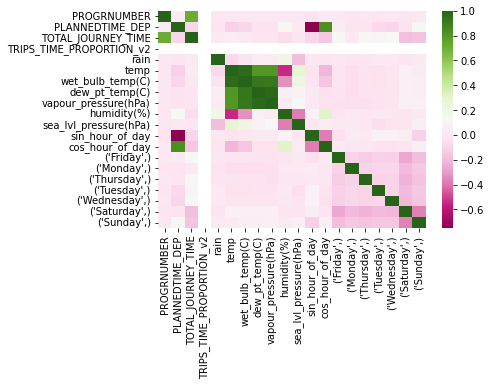

In [84]:
corr=df_dbus.corr()
dataplot = sb.heatmap(corr, cmap="PiYG")
plt.show()

In [95]:
list(dbus_df_list_v3[2].columns.values)

['TRIPID',
 'PROGRNUMBER',
 'PLANNEDTIME_DEP',
 'ROUTEID',
 'ACTUALTIME_ARR_DATETIME',
 'TOTAL_JOURNEY_TIME',
 'TIME_OF_DAY',
 'DAY_OF_WEEK',
 'TRIPS_TIME_PROPORTION_v2',
 'PLANNEDTIME_DEP_R_M5',
 'rain',
 'temp',
 'wet_bulb_temp(C)',
 'dew_pt_temp(C)',
 'vapour_pressure(hPa)',
 'humidity(%)',
 'sea_lvl_pressure(hPa)',
 'sin_hour_of_day',
 'cos_hour_of_day',
 "('Friday',)",
 "('Monday',)",
 "('Saturday',)",
 "('Sunday',)",
 "('Thursday',)",
 "('Tuesday',)",
 "('Wednesday',)"]

In [116]:
features= ['ROUTEID','TOTAL_JOURNEY_TIME','PLANNEDTIME_DEP','rain','temp','wet_bulb_temp(C)','vapour_pressure(hPa)','humidity(%)','sea_lvl_pressure(hPa)','sin_hour_of_day','cos_hour_of_day',"('Friday',)","('Monday',)","('Saturday',)","('Sunday',)","('Thursday',)","('Tuesday',)","('Wednesday',)"]

Creating dataframes with only predictive features

In [117]:
dbus_df_list_v4=[]
for df in dbus_df_list_v3:
    print('='*66)
    print("ROUTEID is ",df['ROUTEID'].unique()[0])
    myfeatures=[]
    df_col_list=list(df.columns.values)
    for col in df_col_list:
        if col in features:
            myfeatures.append(col)
    df_new=df[myfeatures]
    print(df_new.shape)
    print(df_new.columns.values)
    dbus_df_list_v4.append(df_new)

ROUTEID is  33D_61
(35, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  15B_56
(20, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  18_3
(3896, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Sunday',)" "('Thursday',)"
 "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  67_6
(4001, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_te

(30, 17)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Thursday',)" "('Tuesday',)"
 "('Wednesday',)"]
ROUTEID is  16C_28
(242, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Sunday',)" "('Thursday',)"
 "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  40_28
(135, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Sunday',)" "('Thursday',)"
 "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  84A_3
(287, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIM

(1744, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  140_22
(120, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Sunday',)" "('Thursday',)"
 "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  142_13
(155, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  111_10
(63, 17)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_

(39, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  142_8
(251, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  27B_34
(4193, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Sunday',)" "('Thursday',)"
 "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  33B_59
(41, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pr

(2684, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Sunday',)" "('Thursday',)"
 "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  18_4
(3903, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Sunday',)" "('Thursday',)"
 "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  66_16
(35, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  39A_42
(238, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'

(18, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  46E_93
(20, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  68_82
(82, 17)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Thursday',)" "('Tuesday',)"
 "('Wednesday',)"]
ROUTEID is  33A_27
(74, 17)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'hum

(1411, 18)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Saturday',)" "('Sunday',)" "('Thursday',)"
 "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  27B_25
(84, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  76A_28
(126, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_pressure(hPa)' 'humidity(%)'
 'sea_lvl_pressure(hPa)' 'sin_hour_of_day' 'cos_hour_of_day' "('Friday',)"
 "('Monday',)" "('Thursday',)" "('Tuesday',)" "('Wednesday',)"]
ROUTEID is  45A_70
(395, 16)
['PLANNEDTIME_DEP' 'ROUTEID' 'TOTAL_JOURNEY_TIME' 'rain' 'temp'
 'wet_bulb_temp(C)' 'vapour_

Checking for dublicate rows

In [118]:
dublicate_count=0
for df in dbus_df_list_v4:
    # Check for duplicate rows. 
    # Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
    dublicate_count+=df[df.duplicated(keep=False)].shape[0]
    print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number o

Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number o

Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number o

Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number of duplicate rows (including first) in the table is: 0
Number o

In [119]:
dublicate_count

0

In [121]:
write_to_csv('/Chunks/DBUS/Predictive_Model_Chunks/',dbus_df_list_v4,'ROUTEID' )

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33D_61.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/15B_56.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/18_3.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/67_6.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/75_20.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/142_9.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/145_107.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/17_16.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/46A_74.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/122_14.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/145_95.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/150_8.csv

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/15_17.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/123_36.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/40D_101.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/14C_17.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/66X_95.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/14_15.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/185_61.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/40D_106.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/111_8.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/84A_1.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/54A_12.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/44_39

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27_19.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/84_27.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/7_66.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/15B_61.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/123_37.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27_20.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/69X_60.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/39A_45.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/142_8.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27B_34.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33B_59.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/84X_52.cs

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/38_14.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/18_4.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/66_16.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/39A_42.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/61_108.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/25X_12.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/102_10.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/68_85.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/83_18.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/63_28.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/83_29.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/11_42.csv
L

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/123_34.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/123_35.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/66X_102.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/145_94.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/25D_275.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/120_9.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/42_42.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/68_83.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/31D_51.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/40_27.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/42_44.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33_44.

Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41C_79.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/13_62.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/83A_20.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/39_20.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/63_26.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/66B_58.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/42D_50.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/236_10.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/17_10.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41X_119.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/17A_14.csv
Location: /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/66A_38

In [11]:
cols=['ROUTEID','TOTAL_JOURNEY_TIME','PLANNEDTIME_DEP','rain','temp','wet_bulb_temp(C)','vapour_pressure(hPa)','humidity(%)','sea_lvl_pressure(hPa)','sin_hour_of_day','cos_hour_of_day',"('Friday',)","('Monday',)","('Saturday',)","('Sunday',)","('Thursday',)","('Tuesday',)","('Wednesday',)"]
dtypes={'PLANNEDTIME_DEP':'int64','ROUTEID':'category','TOTAL_JOURNEY_TIME':'int16','rain':'float16','temp':'float16','wet_bulb_temp(C)':'float16','vapour_pressure(hPa)':'float16','humidity(%)':'int16','sea_lvl_pressure(hPa)':'float16','sin_hour_of_day':'float16','cos_hour_of_day':'float16','(Friday,)':'int16','(Monday,)':'int16','(Saturday,)':'int16','(Sunday,)':'int16','(Thursday,)':'int16','(Tuesday,)':'int16','(Wednesday,)':'int16'}
x=['/Chunks/DBUS/Predictive_Model_Chunks',dtypes,[],mydateparser]

In [12]:
dbus_df_list_v4=get_chunks(x)

Index at chunk_list 0  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33D_61.csv :  (35, 16)
Index at chunk_list 1  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/15B_56.csv :  (20, 16)
Index at chunk_list 2  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/18_3.csv :  (3896, 18)
Index at chunk_list 3  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/67_6.csv :  (4001, 18)
Index at chunk_list 4  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/75_20.csv :  (33, 16)
Index at chunk_list 5  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/142_9.csv :  (252, 16)
Index at chunk_list 6  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/145_107.csv :  (34, 16)
Index at chunk_list 7  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/17_16.csv :  (307, 15)
Index at chunk_list 8  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/46A_74

Index at chunk_list 90  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/29A_15.csv :  (5001, 18)
Index at chunk_list 91  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/26_27.csv :  (116, 16)
Index at chunk_list 92  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/7_70.csv :  (2278, 18)
Index at chunk_list 93  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/184_28.csv :  (1893, 18)
Index at chunk_list 94  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/140_19.csv :  (6535, 18)
Index at chunk_list 95  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/40E_90.csv :  (221, 18)
Index at chunk_list 96  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41X_130.csv :  (3, 16)
Index at chunk_list 97  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/38_10.csv :  (253, 16)
Index at chunk_list 98  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Mod

Index at chunk_list 204  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/53_21.csv :  (1310, 18)
Index at chunk_list 205  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41X_125.csv :  (107, 16)
Index at chunk_list 206  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/102_9.csv :  (2800, 18)
Index at chunk_list 207  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/38B_40.csv :  (211, 16)
Index at chunk_list 208  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/84A_2.csv :  (34, 16)
Index at chunk_list 209  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/185_60.csv :  (155, 14)
Index at chunk_list 210  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/185_58.csv :  (93, 14)
Index at chunk_list 211  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27A_7.csv :  (25, 18)
Index at chunk_list 212  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predicti

Index at chunk_list 276  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/15_18.csv :  (268, 18)
Index at chunk_list 277  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41X_109.csv :  (18, 16)
Index at chunk_list 278  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/25X_5.csv :  (12, 16)
Index at chunk_list 279  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/31_18.csv :  (3974, 18)
Index at chunk_list 280  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/67X_38.csv :  (24, 16)
Index at chunk_list 281  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/39A_43.csv :  (7814, 18)
Index at chunk_list 282  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/56A_30.csv :  (1607, 18)
Index at chunk_list 283  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33B_56.csv :  (2331, 18)
Index at chunk_list 284  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predi

Index at chunk_list 366  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/16_20.csv :  (7055, 18)
Index at chunk_list 367  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33_69.csv :  (36, 16)
Index at chunk_list 368  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/27B_39.csv :  (41, 16)
Index at chunk_list 369  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/31A_25.csv :  (833, 18)
Index at chunk_list 370  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/65_72.csv :  (681, 18)
Index at chunk_list 371  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33B_58.csv :  (2267, 18)
Index at chunk_list 372  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41X_108.csv :  (6, 16)
Index at chunk_list 373  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33X_48.csv :  (39, 16)
Index at chunk_list 374  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictiv

Index at chunk_list 439  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/68_82.csv :  (82, 17)
Index at chunk_list 440  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/33A_27.csv :  (74, 17)
Index at chunk_list 441  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/63_25.csv :  (782, 18)
Index at chunk_list 442  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/104_16.csv :  (1011, 18)
Index at chunk_list 443  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/69_45.csv :  (530, 17)
Index at chunk_list 444  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/41_22.csv :  (373, 18)
Index at chunk_list 445  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/17A_15.csv :  (1710, 16)
Index at chunk_list 446  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/185_51.csv :  (229, 16)
Index at chunk_list 447  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predicti

Index at chunk_list 529  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/39X_1.csv :  (168, 16)
Index at chunk_list 530  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/37_14.csv :  (4981, 18)
Index at chunk_list 531  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/46A_68.csv :  (58, 16)
Index at chunk_list 532  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/56A_31.csv :  (1680, 18)
Index at chunk_list 533  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/51D_47.csv :  (24, 16)
Index at chunk_list 534  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/25_272.csv :  (1608, 18)
Index at chunk_list 535  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/49_28.csv :  (3093, 18)
Index at chunk_list 536  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predictive_Model_Chunks/63_30.csv :  (1411, 18)
Index at chunk_list 537  is  /home/team8/notebook/Pelin/Chunks/DBUS/Predi

In [16]:
dbus_df_list_v4[587].tail(5)

,PLANNEDTIME_DEP,ROUTEID,TOTAL_JOURNEY_TIME,rain,temp,wet_bulb_temp(C),vapour_pressure(hPa),humidity(%),sea_lvl_pressure(hPa),sin_hour_of_day,cos_hour_of_day,"('Friday',)","('Monday',)","('Saturday',)","('Sunday',)","('Thursday',)","('Tuesday',)","('Wednesday',)"
2040,75616,40D_103,2889,0.0,10.296875,8.703125,9.898438,79,1034.0,-0.707031,0.707031,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2041,52646,40D_103,3119,0.0,10.000000,8.000000,9.101562,74,1034.0,-0.500000,-0.866211,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2042,67140,40D_103,2840,0.0,9.898438,7.898438,9.000000,74,1035.0,-1.000000,-0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2043,71671,40D_103,2742,0.0,9.898438,8.000000,9.203125,75,1035.0,-0.866211,0.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2044,79826,40D_103,3493,0.0,9.796875,7.898438,9.101562,75,1035.0,-0.500000,0.866211,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Findings
1. PROGRNUMBER have high correlation with total trip time. However, our model relies on finding unique sequence of bus stop in each route because we don't have means to input different PROGRNUMBERs for same ROUTEID at backend. Therefore we will drop this feature from our predictive model features list. But while building STOPPAIRS for each ROUTEID table we can extract stop pairs from trips with max PROGRAMNUMBER.
2. After leaving rows where trip is at last bus stop in sequence by dropping rows where TRIPS_TIME_PROPORTION_v2 is not 1, we end up with bunch of ROUTEID chunks where sample size is very low. " in regression analysis, many researchers say that there should be at least 10 observations per variable. If we are using three independent variables, then a clear rule would be to have a minimum sample size of 30." https://www.statisticssolutions.com/dissertation-resources/sample-size-calculation-and-sample-size-justification/sample-size-formula/#:~:text=For%20example%2C%20in%20regression%20analysis,minimum%20sample%20size%20of%2030.
Since we have 16 to 10 variable per ROUTEID, our sample sizes should be in between min 100 or min 160 per ROUTEID. Therefore depend on number of columns in a ROUTEID dataframe(df)  if df.shape[1] is less then number of columns * 10, we should consider removing that ROUTEID from model building. Because we don't have sufficent number of observations to come up with a predictive model for that ROUTEID. 




In [23]:
dbus_df_list_v4[0].shape[0]

35

In [24]:
dbus_df_list_v4[0].shape[1]

16

In [26]:
small_samplesize_route_counter=0
small_samplesize_row_counter=0
total_row_count=0
for df in dbus_df_list_v4:
    total_row_count+=df.shape[0]
    if df.shape[0] < df.shape[1]*10:
        small_samplesize_row_counter+=df.shape[0]
        small_samplesize_route_counter+=1
print("Number of routes need to be dropped: ",small_samplesize_route_counter , " , number of rows need to be dropped: ",small_samplesize_row_counter, " corresponds to ",small_samplesize_row_counter/total_row_count, " percentage of total dataset" )

Number of routes need to be dropped:  283  , number of rows need to be dropped:  17729  corresponds to  0.02730453745999575  percentage of total dataset


From this we can see that 283 routes are insignificant and they only make 2.7% of total data so we decide to drop those routeids and develop model for remaining 305 routeid

In [14]:
Important_ROUTEID_LIST=[]
for df in dbus_df_list_v4:
    if df.shape[0] >= df.shape[1]*10:
        Important_ROUTEID_LIST.append(df['ROUTEID'].unique()[0])
df_ROUTEID_LIST=pd.DataFrame(Important_ROUTEID_LIST, columns=['ROUTEID'])
df_ROUTEID_LIST.to_csv('IMPORTANT_ROUTEIDS.csv',index=False)